# Stock Performance based on fundamental and technical indicators

#### Introduction: The purpose of this project is to determine if there is any combination of fundamental and technical indicators which will prove to be indicative of performance.  Fundamental data was purchased from simfin.com.  Daily stock data is a free download from eoddata.com.  Both sources would require upgrades to use in a real-time or near real-time environment.  Popular technical and fundamental technical indicators will be chose based on online research.  Histograms will be created to determine the shape of the data, and colinnearity will be measured to help determine variable selection. Finally, two deep learning techniques are used to model the data.  A logistic model using tensorflow, and a multi-level perceptron classification model

In [1]:
import pandas as pd
import numpy as np
import glob
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one

# K Nearest Neighbors classification algorithm

from sklearn.preprocessing import OneHotEncoder
from scipy.stats import linregress
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import math

from sklearn import svm, datasets
import simfin as sf
from simfin.names import *
from datetime import datetime
from datetime import timedelta
import tempfile
from sklearn.decomposition import NMF
from itertools import permutations

import tensorflow as tf
from tensorflow.keras import Model, losses, optimizers
import tensorflow.keras.layers as L


2024-04-12 09:33:32.564471: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 09:33:32.564556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 09:33:32.651150: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 09:33:32.820546: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 09:33:34.668203: W tensorflow/compiler/tf2

In [3]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=False, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 

# Initial Importation and Cleaning

In [ ]:
sf.set_api_key('###################')

# Set the local directory where data-files are stored.
# The dir will be created if it does not already exist.
sf.set_data_dir('~/simfin_data/')

# Load the annual Income Statements for all companies in the US.
# The data is automatically downloaded if you don't have it already.
income_data = sf.load_income(variant='quarterly', market='us')
company_data = sf.load_companies()
industry_data = sf.load_industries()

In [ ]:
income_data

In [ ]:
income_data2 = income_data[['Shares (Basic)','Net Income (Common)','Revenue']].copy()
income_data2['earnings_share'] = income_data2['Net Income (Common)']  / income_data2['Shares (Basic)'] 

In [ ]:
income_data3 = income_data2.reset_index()

In [ ]:
income_data3['annual_earnings'] = income_data3.groupby('Ticker')['Net Income (Common)'].rolling(window=4, min_periods=4).sum().reset_index()['Net Income (Common)']
income_data3['annual_revenue'] = income_data3.groupby('Ticker')['Revenue'].rolling(window=4, min_periods=4).sum().reset_index()['Revenue']

In [ ]:
income_data3['earnings_shift1'] = income_data3.groupby('Ticker')['Net Income (Common)'].shift(1)
income_data3['revenue_shift1'] = income_data3.groupby('Ticker')['annual_revenue'].shift(1)

In [ ]:
income_data3['earnings_growth'] = income_data3['annual_earnings'] / income_data3['earnings_shift1']
income_data3['revenue_growth'] = income_data3['annual_revenue'] / income_data3['revenue_shift1']

In [ ]:
company_data2 = company_data['IndustryId'].copy().to_frame()
company_data3 = company_data2.reset_index().merge(industry_data, how='inner', left_on='IndustryId', right_on='IndustryId')

In [ ]:
income_data4 = income_data3.reset_index().merge(company_data3, how='inner',left_on='Ticker', right_on = 'Ticker')

In [ ]:
income_data4['Report Date_Next'] = income_data4.groupby(['Ticker'])['Report Date'].shift(-1)

In [ ]:
income_data4['Report Date2'] = income_data4['Report Date'].dt.strftime('%Y%m%d')

In [ ]:
income_data4['Report Date_Next'] = income_data4['Report Date_Next'].fillna(pd.to_datetime(income_data4['Report Date2']) + timedelta(days=90)).dt.strftime('%Y%m%d')

In [ ]:
income_data4 = income_data4[['Ticker','Report Date', 'earnings_share','Industry','Sector','Report Date_Next','Report Date2','revenue_growth','earnings_growth']]

#### Nasdaq and NYSE data was pre downloaded to my computer after purchase

In [ ]:
directoryPath = "F:/Stocks/ST/NASDAQ_FINAL/"
nasdaq_working_data = pd.DataFrame()
for file_name in glob.glob(directoryPath+'*.txt'):
    x = pd.read_csv(file_name, low_memory=False)
    nasdaq_working_data = pd.concat([nasdaq_working_data,x],axis=0)

In [ ]:
nasdaq = nasdaq_working_data.rename(columns={"<ticker>": "ticker", "<date>": "date"
                          ,"<open>": "open"
                           ,"<high>": "high"
                           ,"<low>": "low"
                           ,"<close>": "close"
                           ,"<vol>": "volume"
                          })

In [ ]:
directoryPath = "F:/Stocks/ST/NYSE_FINAL/"
nyse_working_data = pd.DataFrame()
for file_name in glob.glob(directoryPath+'*.txt'):
    x = pd.read_csv(file_name, low_memory=False)
    nyse_working_data = pd.concat([nyse_working_data,x],axis=0)

In [ ]:
nyse = nyse_working_data.rename(columns={"<ticker>": "ticker", "<date>": "date"
                          ,"<open>": "open"
                           ,"<high>": "high"
                           ,"<low>": "low"
                           ,"<close>": "close"
                           ,"<vol>": "volume"
                          })

In [ ]:
final_data = pd.concat([nasdaq,nyse],axis=0)

In [ ]:
income_data4 = income_data4.rename(columns = {'Report Date_Next': 'report_date_next', 'Report Date2': 'report_date2'})

In [ ]:
final_data.to_csv('~/final_data.csv')

In [ ]:
income_data4.to_csv('~/income_data.csv')

In [4]:
income_data4 = pd.read_csv('~/Machine_Learning/Deep_Learning/income_data.csv')

In [5]:
final_data = pd.read_csv('~/Machine_Learning/Deep_Learning/final_data.csv')

In [6]:
final_data = final_data.drop(columns='Ticker')

#### Joining fundamentals with historical datasets

In [7]:
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

cond_join = '''select dF_left.*, df_right.* 
            from final_data as df_left
            join income_data4 as df_right
            on
                df_left.Ticker = df_right.Ticker
                and df_left.date > df_right.report_date2
                and df_left.date <= df_right.report_date_next
            '''


final_data_with_fund_temp = pysqldf(cond_join)

In [8]:
final_data_with_fund_temp.to_csv('~/Machine_Learning/Deep_Learning/final_data_with_fund_temp.csv')

In [9]:
final_data_with_fund_temp = pd.read_csv('~/Machine_Learning/Deep_Learning/final_data_with_fund_temp.csv')

In [10]:
final_data = final_data_with_fund_temp

In [11]:
final_data = final_data.loc[:,~final_data.columns.duplicated()].copy()

In [12]:
final_data = final_data.drop(columns = ('Unnamed: 0'))

In [13]:
final_data['earnings_days'] = pd.to_datetime(final_data['date'], format='%Y%m%d') - pd.to_datetime(final_data['report_date2'], format='%Y%m%d')

In [14]:
final_data['earnings_1wk'] = np.where(final_data['earnings_days'] < timedelta(days=7),1,0)
final_data['earnings_2wk'] = np.where(final_data['earnings_days'] < timedelta(days=14),1,0)
final_data['earnings_4wk'] = np.where(final_data['earnings_days'] < timedelta(days=28),1,0)
final_data['earnings_8wk'] = np.where(final_data['earnings_days'] < timedelta(days=56),1,0)

## Removing Tickers with High and Low Closing Prices

In [15]:
final_low = final_data.loc[final_data['close'] < 10]
low_ticks = final_low['ticker'].unique()
final_data2 = final_data[~final_data['ticker'].isin(low_ticks)]

In [16]:
final_high = final_data2.loc[final_data2['close'] > 300]
high_ticks = final_high['ticker'].unique()
final_data3 = final_data2[~final_data2['ticker'].isin(high_ticks)].copy()

## Removing Low Volume Tickers

In [17]:
final_data4 = final_data3.loc[final_data3['volume'] > 0].copy()

In [18]:
final_data4['date2'] = pd.to_datetime(final_data4['date'], format='%Y%m%d')

In [19]:
final_data4['month'] = final_data4['date2'].dt.month
final_data4['year'] = final_data4['date2'].dt.year

In [20]:
volume_summary = final_data4.groupby(['ticker','year','month']).mean('volume').reset_index()

In [21]:
low_volume_tickers = volume_summary.loc[volume_summary['volume'] < 50000]['ticker'].unique()

In [22]:
len(low_volume_tickers)

182

In [23]:
final_data5 = final_data4[~final_data4['ticker'].isin(low_volume_tickers)].copy()

In [24]:
final_data5 = final_data5.drop(columns = ['month','year','date'])

In [25]:
len(final_data5)

1661874

In [26]:
len(final_data5['ticker'].unique())

1110

# Adding Technical Indicator Precursors

In [27]:
final_data_precursor = final_data5.set_index(['ticker', 'date2']).copy()

## Adding Volatility

In [28]:
final_data_precursor['close-1'] = final_data_precursor['close'].groupby(level=["ticker"]).shift(1)
final_data_precursor['pct_chg'] = (final_data_precursor['close'] / final_data_precursor['close-1']) - 1

final_data_precursor['volatility'] = final_data_precursor['pct_chg'].groupby(level=["ticker"]).rolling(min_periods=30, window=30).std().droplevel(0,axis = 0)*(252**0.5)
final_data_precursor = final_data_precursor.drop(columns = ['close-1','pct_chg'])

In [29]:
final_data_precursor

,,Unnamed: 0.2,open,high,low,close,volume,Report Date,earnings_share,Industry,Sector,...,report_date_next.1,report_date2.1,revenue_growth.1,earnings_growth.1,earnings_days,earnings_1wk,earnings_2wk,earnings_4wk,earnings_8wk,volatility
ticker,date2,,,,,,,,,,,,,,,,,,,,,
ADI,2014-05-01,0,51.38,51.530,50.760,50.82,1529000,2014-04-30 00:00:00.000000,0.597895,Semiconductors,Technology,...,20140731,20140430,NaN,NaN,1 days,1,1,1,1,NaN
AMAT,2014-05-01,2,19.13,19.290,18.860,18.88,17221300,2014-04-30 00:00:00.000000,0.215461,Semiconductors,Technology,...,20140731,20140430,NaN,NaN,1 days,1,1,1,1,NaN
AVAV,2014-05-01,3,33.65,34.240,33.060,33.84,311000,2014-04-30 00:00:00.000000,0.356750,Aerospace & Defense,Industrials,...,20140731,20140430,NaN,NaN,1 days,1,1,1,1,NaN
CAKE,2014-05-01,4,45.14,45.640,44.780,45.59,1002900,2014-04-30 00:00:00.000000,0.443748,Restaurants,Consumer Cyclical,...,20140731,20140430,NaN,NaN,1 days,1,1,1,1,NaN
CASY,2014-05-01,5,68.38,68.740,67.340,68.41,190300,2014-04-30 00:00:00.000000,0.543956,Retail - Defensive,Consumer Defensive,...,20140731,20140430,NaN,NaN,1 days,1,1,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,2023-10-17,4680500,119.04,119.978,118.865,119.44,1267400,2023-09-30 00:00:00.000000,1.478948,Restaurants,Consumer Cyclical,...,20231231,20230930,1.009727,3.590909,17 days,0,0,1,1,0.195956
YUMC,2023-10-17,4680501,52.66,53.190,52.600,52.90,1048500,2023-09-30 00:00:00.000000,0.586538,Restaurants,Consumer Cyclical,...,20231231,20230930,1.022138,3.974619,17 days,0,0,1,1,0.294624
ZBH,2023-10-17,4680502,104.37,108.020,104.090,106.59,1455000,2023-09-30 00:00:00.000000,0.778842,Medical Devices,Healthcare,...,20231231,20230930,1.011646,2.262154,17 days,0,0,1,1,0.301295


### Money Flow Index

In [30]:
final_data_precursor = final_data_precursor.sort_index(ascending=True)
final_data_precursor['typical'] = (final_data_precursor['close'] + final_data_precursor['high'] + final_data_precursor['low']) / 3
final_data_precursor['money_flow'] = final_data_precursor['typical'] *  final_data_precursor['volume']
shifted = final_data_precursor.groupby(level=["ticker"]).shift(1)['money_flow'].to_frame()
final_data_precursor = final_data_precursor.join(shifted, rsuffix='_lag')
final_data_precursor['net_money_flow'] = final_data_precursor['money_flow'] - final_data_precursor['money_flow_lag']
final_data_precursor['pos_money_flow'] = final_data_precursor[final_data_precursor['net_money_flow'] > 0]['net_money_flow']
final_data_precursor['pos_money_flow'].fillna(0, inplace=True)
final_data_precursor['neg_money_flow'] = -final_data_precursor[final_data_precursor['net_money_flow'] < 0]['net_money_flow']
final_data_precursor['neg_money_flow'].fillna(0, inplace=True)
final_data_precursor['pos_money_flow30'] = final_data_precursor['pos_money_flow'].groupby(level=["ticker"]).rolling(min_periods=30, window=30).sum().droplevel(0,axis = 0)
final_data_precursor['neg_money_flow30'] = final_data_precursor['neg_money_flow'].groupby(level=["ticker"]).rolling(min_periods=30, window=30).sum().droplevel(0,axis = 0)
final_data_precursor['money_ratio'] = final_data_precursor['pos_money_flow30'] / final_data_precursor['neg_money_flow30']
final_data_precursor['money_flow_index'] =    100 - (100/(1+ final_data_precursor['money_ratio']))

final_data_precursor = final_data_precursor.drop(columns = ['net_money_flow','money_flow','money_flow_lag',
                                                            'pos_money_flow','neg_money_flow','pos_money_flow30',
                                                            'neg_money_flow30','money_ratio','typical'])


/tmp/ipykernel_1121241/1771104260.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_data_precursor['pos_money_flow'].fillna(0, inplace=True)
/tmp/ipykernel_1121241/1771104260.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value,

### Exponential Moving Averages

In [31]:
final_data_precursor['ema_12'] = final_data_precursor['close'].groupby(level=["ticker"]).ewm(span=12,min_periods=12,adjust=False).mean().droplevel(0,axis = 0)
final_data_precursor['ema_26'] = final_data_precursor['close'].groupby(level=["ticker"]).ewm(span=26,min_periods=26,adjust=False).mean().droplevel(0,axis = 0)
final_data_precursor['ema_40'] = final_data_precursor['close'].groupby(level=["ticker"]).ewm(span=40,min_periods=40,adjust=False).mean().droplevel(0,axis = 0)
final_data_precursor['ema_100'] = final_data_precursor['close'].groupby(level=["ticker"]).ewm(span=100,min_periods=100, adjust=False).mean().droplevel(0,axis = 0)
final_data_precursor['ema_200'] = final_data_precursor['close'].groupby(level=["ticker"]).ewm(span=200,min_periods=200, adjust=False).mean().droplevel(0,axis = 0)

final_data_precursor['ema_12_Dist'] = (final_data_precursor['ema_12'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['ema_26_Dist'] = (final_data_precursor['ema_26'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['ema_40_Dist'] = (final_data_precursor['ema_40'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['ema_100_Dist'] = (final_data_precursor['ema_100'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['ema_200_Dist'] = (final_data_precursor['ema_200'] - final_data_precursor['close']) / final_data_precursor['close']


### KST Indicator

####      ROC

In [32]:
final_data_precursor['Close-10'] = final_data_precursor['close'].groupby(level=["ticker"]).shift(10)
final_data_precursor['Close-15'] = final_data_precursor['close'].groupby(level=["ticker"]).shift(15)
final_data_precursor['Close-20'] = final_data_precursor['close'].groupby(level=["ticker"]).shift(20)
final_data_precursor['Close-30'] = final_data_precursor['close'].groupby(level=["ticker"]).shift(30)

final_data_precursor['ROC10'] = (final_data_precursor['close'] - final_data_precursor['Close-10'])/ final_data_precursor['Close-10'] * 100
final_data_precursor['ROC15'] = (final_data_precursor['close'] - final_data_precursor['Close-15'])/ final_data_precursor['Close-15'] * 100
final_data_precursor['ROC20'] = (final_data_precursor['close'] - final_data_precursor['Close-20'])/ final_data_precursor['Close-20'] * 100
final_data_precursor['ROC30'] = (final_data_precursor['close'] - final_data_precursor['Close-30'])/ final_data_precursor['Close-30'] * 100

In [33]:
final_data_precursor['ROC10MA'] = final_data_precursor['ROC10'].groupby(level=["ticker"]).rolling(min_periods=10, window=10).mean().droplevel(0,axis = 0)
final_data_precursor['ROC15MA'] = final_data_precursor['ROC15'].groupby(level=["ticker"]).rolling(min_periods=15, window=15).mean().droplevel(0,axis = 0)
final_data_precursor['ROC20MA'] = final_data_precursor['ROC20'].groupby(level=["ticker"]).rolling(min_periods=20, window=20).mean().droplevel(0,axis = 0)
final_data_precursor['ROC30MA'] = final_data_precursor['ROC30'].groupby(level=["ticker"]).rolling(min_periods=30, window=30).mean().droplevel(0,axis = 0)

In [34]:
final_data_precursor['KST'] = (final_data_precursor['ROC10MA'] + final_data_precursor['ROC15MA']*2 
                               + final_data_precursor['ROC20MA']*3 + final_data_precursor['ROC30MA']*4)/10
final_data_precursor['KST-1'] = final_data_precursor['KST'].groupby(level=["ticker"]).shift(1)
final_data_precursor['KST-2'] = final_data_precursor['KST'].groupby(level=["ticker"]).shift(2)
final_data_precursor['KST-3'] = final_data_precursor['KST'].groupby(level=["ticker"]).shift(3)
final_data_precursor['KST-4'] = final_data_precursor['KST'].groupby(level=["ticker"]).shift(4)
final_data_precursor['KST-5'] = final_data_precursor['KST'].groupby(level=["ticker"]).shift(5)
final_data_precursor['KST-6'] = final_data_precursor['KST'].groupby(level=["ticker"]).shift(6)
final_data_precursor['KST-7'] = final_data_precursor['KST'].groupby(level=["ticker"]).shift(7)
final_data_precursor['KST-8'] = final_data_precursor['KST'].groupby(level=["ticker"]).shift(8)

In [35]:
final_data_precursor['KST_Signal'] = (final_data_precursor['KST'] + final_data_precursor['KST-1'] + 
                                      final_data_precursor['KST-2'] + final_data_precursor['KST-3'] + 
                                      final_data_precursor['KST-4'] + final_data_precursor['KST-5'] +
                                      final_data_precursor['KST-6'] + final_data_precursor['KST-7'] +
                                      final_data_precursor['KST-8'])/9


In [36]:
final_data_precursor['KST2'] = final_data_precursor['KST'] / final_data_precursor['close']
final_data_precursor['KST_Signal2'] = final_data_precursor['KST_Signal'] / final_data_precursor['close']

In [37]:
final_data_precursor = final_data_precursor.drop(columns = ['ROC10','ROC15','ROC20','ROC30',
                                                            'ROC10MA','ROC15MA','ROC20MA','ROC30MA',
                                                            'KST-1','KST-2','KST-3',
                                                            'KST-4','KST-5','KST-6',
                                                            'KST-7','KST-8'])

## Trendlines(Excluded for the time being)

## Bollinger Bands

In [38]:
final_data_precursor['sma_20'] = final_data_precursor['close'].groupby(level=["ticker"]).rolling(min_periods=20, window=20).mean().droplevel(0,axis = 0)
final_data_precursor['std_20'] = final_data_precursor['close'].groupby(level=["ticker"]).rolling(min_periods=20, window=20).std().droplevel(0,axis = 0)
final_data_precursor['Boll_Upper'] = final_data_precursor['sma_20'] + (final_data_precursor['std_20'] * 2)
final_data_precursor['Boll_Mid'] = final_data_precursor['sma_20']
final_data_precursor['Boll_Lower'] = final_data_precursor['sma_20'] - (final_data_precursor['std_20'] * 2)

final_data_precursor['Boll_Upper_Dist'] = ((final_data_precursor['Boll_Upper'] / final_data_precursor['close']) - 1) / final_data_precursor['volatility']
final_data_precursor['Boll_Mid_Dist'] = ((final_data_precursor['Boll_Mid'] / final_data_precursor['close']) - 1) / final_data_precursor['volatility']
final_data_precursor['Boll_Lower_Dist'] = ((final_data_precursor['Boll_Lower'] /final_data_precursor['close']) - 1) / final_data_precursor['volatility']

## Relative Strength Index (RSI): 

In [39]:
final_data_precursor['delta']  = final_data_precursor['close'].groupby(level=["ticker"]).diff() 
final_data_precursor['gain']  = final_data_precursor['delta'].where(final_data_precursor['delta'] > 0, 0) 
final_data_precursor['loss']  = -final_data_precursor['delta'].where(final_data_precursor['delta'] < 0, 0) 
 
# Calculate average gain and loss 
final_data_precursor['average_gain']  = final_data_precursor['gain'].groupby(level=["ticker"]).rolling(window=14).mean().droplevel(0,axis = 0) 
final_data_precursor['average_loss']  = final_data_precursor['loss'].groupby(level=["ticker"]).rolling(window=14).mean().droplevel(0,axis = 0)
 
# Calculate RSI 
final_data_precursor['rs']  = final_data_precursor['average_gain'] / final_data_precursor['average_loss'].abs() 
final_data_precursor['RSI'] = 100 - (100 / (1 + final_data_precursor['rs'])) 

final_data_precursor = final_data_precursor.drop(columns = ['delta','gain','average_gain','average_loss','loss','rs'])

## MACD 

In [40]:
final_data_precursor['MACD_Line'] = final_data_precursor['ema_12'] - final_data_precursor['ema_26']
final_data_precursor['MACD_Signal'] = final_data_precursor['MACD_Line'].groupby(level=["ticker"]).ewm(span=9,min_periods=9,adjust=False).mean().droplevel(0,axis = 0)
final_data_precursor['MACD_Histogram'] = final_data_precursor['MACD_Line'] - final_data_precursor['MACD_Signal']

final_data_precursor['MACD_Line2'] = final_data_precursor['MACD_Line'] / final_data_precursor['close']
final_data_precursor['MACD_Signal2'] = final_data_precursor['MACD_Signal'] / final_data_precursor['close']
final_data_precursor['MACD_Histogram2'] = final_data_precursor['MACD_Histogram'] / final_data_precursor['close']

## Stochastic Oscillator

In [41]:
final_data_precursor['Lowest_Low'] = final_data_precursor['low'].groupby(level=["ticker"]).rolling(min_periods=14, window=14).min().droplevel(0,axis = 0)
final_data_precursor['Highest_High'] = final_data_precursor['high'].groupby(level=["ticker"]).rolling(min_periods=14, window=14).max().droplevel(0,axis = 0)
final_data_precursor['SO_K'] = (final_data_precursor['close'] - final_data_precursor['Lowest_Low'])  / (final_data_precursor['Highest_High'] - final_data_precursor['Lowest_Low']) * 100
final_data_precursor['SO_D'] = final_data_precursor['SO_K'].groupby(level=["ticker"]).rolling(min_periods=3, window=3).mean().droplevel(0,axis = 0)

## Average True Range (ATR)

In [42]:
final_data_precursor['Close_1'] = final_data_precursor['close'].groupby(level=["ticker"]).shift(1)
final_data_precursor['ATR_A'] = abs(final_data_precursor['high']-final_data_precursor['low'])
final_data_precursor['ATR_B'] = abs(final_data_precursor['high']-final_data_precursor['Close_1'])
final_data_precursor['ATR_C']  = abs(final_data_precursor['low']-final_data_precursor['Close_1'])
final_data_precursor['TR'] = final_data_precursor[["ATR_A", "ATR_B","ATR_C"]].max(axis=1)  
final_data_precursor['ATR'] = final_data_precursor['TR'].groupby(level=["ticker"]).rolling(min_periods=14, window=14).mean().droplevel(0,axis = 0)
final_data_precursor['ATR2'] = final_data_precursor['ATR'] / final_data_precursor['close']


final_data_precursor = final_data_precursor.drop(columns = ['Close_1','ATR_A','ATR_B','ATR_C','TR'])

## Fibonacci Levels

In [43]:
final_data_precursor['fibo0'] = final_data_precursor['close'].groupby(level=["ticker"]).rolling(min_periods=90, window=90).min().droplevel(0,axis = 0)
final_data_precursor['fibo100'] = final_data_precursor['close'].groupby(level=["ticker"]).rolling(min_periods=90, window=90).max().droplevel(0,axis = 0)
final_data_precursor['fibo25'] = ((final_data_precursor['fibo100'] - final_data_precursor['fibo0']) * .25) + final_data_precursor['fibo0']
final_data_precursor['fibo38'] = ((final_data_precursor['fibo100'] - final_data_precursor['fibo0']) * .38) + final_data_precursor['fibo0']
final_data_precursor['fibo50'] = ((final_data_precursor['fibo100'] - final_data_precursor['fibo0']) * .50) + final_data_precursor['fibo0']
final_data_precursor['fibo618'] = ((final_data_precursor['fibo100'] - final_data_precursor['fibo0']) * .618) + final_data_precursor['fibo0']
final_data_precursor['fibo786'] = ((final_data_precursor['fibo100'] - final_data_precursor['fibo0']) * .786) + final_data_precursor['fibo0']
final_data_precursor['fibo886'] = ((final_data_precursor['fibo100'] - final_data_precursor['fibo0']) * .886) + final_data_precursor['fibo0']


final_data_precursor['fibo0_Dist'] = (final_data_precursor['fibo0'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['fibo25_Dist'] = (final_data_precursor['fibo25'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['fibo50_Dist'] = (final_data_precursor['fibo50'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['fibo618_Dist'] = (final_data_precursor['fibo618'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['fibo786_Dist'] = (final_data_precursor['fibo786'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['fibo886_Dist'] = (final_data_precursor['fibo886'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['fibo100_Dist'] = (final_data_precursor['fibo100'] - final_data_precursor['close']) / final_data_precursor['close']

## Ichimoku Cloud

In [44]:
final_data_precursor['IC_9_High'] = final_data_precursor['high'].groupby(level=["ticker"]).rolling(min_periods=9, window=9).max().droplevel(0,axis = 0)
final_data_precursor['IC_9_Low'] = final_data_precursor['low'].groupby(level=["ticker"]).rolling(min_periods=9, window=9).min().droplevel(0,axis = 0)
final_data_precursor['IC_26_High'] = final_data_precursor['high'].groupby(level=["ticker"]).rolling(min_periods=26, window=26).max().droplevel(0,axis = 0)
final_data_precursor['IC_26_Low'] = final_data_precursor['low'].groupby(level=["ticker"]).rolling(min_periods=26, window=26).min().droplevel(0,axis = 0)
final_data_precursor['IC_52_High'] = final_data_precursor['high'].groupby(level=["ticker"]).rolling(min_periods=52, window=52).max().droplevel(0,axis = 0)
final_data_precursor['IC_52_Low'] = final_data_precursor['low'].groupby(level=["ticker"]).rolling(min_periods=52, window=52).min().droplevel(0,axis = 0)

final_data_precursor['IC_CL'] = (final_data_precursor['IC_9_High'] + final_data_precursor['IC_9_Low']) / 2
final_data_precursor['IC_BL'] = (final_data_precursor['IC_26_High'] + final_data_precursor['IC_26_Low']) / 2

final_data_precursor['LS_A'] = (final_data_precursor['IC_CL'] + final_data_precursor['IC_BL']) / 2
final_data_precursor['LS_B'] = (final_data_precursor['IC_52_High'] + final_data_precursor['IC_52_Low']) / 2

final_data_precursor['Close_26'] = final_data_precursor['close'].groupby(level=["ticker"]).shift(26)

final_data_precursor = final_data_precursor.drop(columns = ['IC_9_High','IC_9_Low','IC_26_High','IC_26_Low','IC_52_High','IC_52_Low'])


final_data_precursor['IC_CL2'] = (final_data_precursor['IC_CL']  - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['IC_BL2'] = (final_data_precursor['IC_BL'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['LS_A2'] = (final_data_precursor['LS_A'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['LS_B2'] = (final_data_precursor['LS_B'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['Close_26_2'] =  (final_data_precursor['Close_26'] - final_data_precursor['close']) / final_data_precursor['close']

## On-Balance Volume (OBV)

In [45]:
final_data_precursor['Close_1'] = final_data_precursor['close'].groupby(level=["ticker"]).shift(1)
final_data_precursor['OBV_A'] = np.where(final_data_precursor['close']  > final_data_precursor['Close_1'],final_data_precursor['volume'],0)
final_data_precursor['OBV_A'] = np.where(final_data_precursor['close']  < final_data_precursor['Close_1'],-final_data_precursor['volume'],final_data_precursor['OBV_A'])
final_data_precursor['OBV_A'] = np.where(final_data_precursor['close']  == final_data_precursor['Close_1'],0,final_data_precursor['OBV_A'])
final_data_precursor['OBV'] = final_data_precursor['OBV_A'].groupby(level=["ticker"]).rolling(min_periods=26, window=26).sum().droplevel(0,axis = 0)
final_data_precursor = final_data_precursor.drop(columns = ['Close_1','OBV_A'])

final_data_precursor['vol26_avg'] = final_data_precursor['volume'].groupby(level=["ticker"]).rolling(min_periods=26, window=26).mean().droplevel(0,axis = 0)
final_data_precursor['OBV2'] = final_data_precursor['OBV'] / final_data_precursor['vol26_avg']

In [46]:
final_data_precursor

Unnamed: 0.2     open     high      low    close   volume  \
ticker date2                                                                   
A      2014-05-01       2549543  38.5837  39.2489  38.3834  38.9628  1472400   
       2014-05-02       2549599  38.9843  39.3348  38.6910  39.0129  2080900   
       2014-05-05       2549655  38.8484  39.5851  38.5479  39.5780  2087200   
       2014-05-06       2549711  39.3991  39.6638  38.9557  39.3491  2224200   
       2014-05-07       2549767  39.4349  39.4349  38.8197  39.3634  2219200   
...                         ...      ...      ...      ...      ...      ...   
ZUMZ   2023-10-12       2542953  17.2200  17.2200  16.3100  16.5000   256700   
       2023-10-13       2544607  16.4800  16.4800  15.6700  15.8100   409400   
       2023-10-16       2546266  15.9500  16.9600  15.9500  16.8600   266900   
       2023-10-17       2547923  16.8600  17.7600  16.6550  17.6900   298400   
       2023-10-18       2549541  17.5200  17.5800  17.2400  17.2400    45812   

                                  Report Date  earnings_share  \
ticker date2                                                    
A      2014-05-01  2014-04-30 00:00:00.000000        0.417417   
       2014-05-02  2014-04-30 00:00:00.000000        0.417417   
       2014-05-05  2014-04-30 00:00:00.000000        0.417417   
       2014-05-06  2014-04-30 00:00:00.000000        0.417417   
       2014-05-07  2014-04-30 00:00:00.000000        0.417417   
...                                       ...             ...   
ZUMZ   2023-10-12  2023-07-31 00:00:00.000000       -0.440630   
       2023-10-13  2023-07-31 00:00:00.000000       -0.440630   
       2023-10-16  2023-07-31 00:00:00.000000       -0.440630   
       2023-10-17  2023-07-31 00:00:00.000000       -0.440630   
       2023-10-18  2023-07-31 00:00:00.000000       -0.440630   

                                         Industry             Sector  ...  \
ticker date2                                                          ...   
A      2014-05-01  Medical Diagnostics & Research         Healthcare  ...   
       2014-05-02  Medical Diagnostics & Research         Healthcare  ...   
       2014-05-05  Medical Diagnostics & Research         Healthcare  ...   
       2014-05-06  Medical Diagnostics & Research         Healthcare  ...   
       2014-05-07  Medical Diagnostics & Research         Healthcare  ...   
...                                           ...                ...  ...   
ZUMZ   2023-10-12    Retail - Apparel & Specialty  Consumer Cyclical  ...   
       2023-10-13    Retail - Apparel & Specialty  Consumer Cyclical  ...   
       2023-10-16    Retail - Apparel & Specialty  Consumer Cyclical  ...   
       2023-10-17    Retail - Apparel & Specialty  Consumer Cyclical  ...   
       2023-10-18    Retail - Apparel & Specialty  Consumer Cyclical  ...   

                     LS_B  Close_26    IC_CL2    IC_BL2     LS_A2     LS_B2  \
ticker date2                                                                  
A      2014-05-01     NaN       NaN       NaN       NaN       NaN       NaN   
       2014-05-02     NaN       NaN       NaN       NaN       NaN       NaN   
       2014-05-05     NaN       NaN       NaN       NaN       NaN       NaN   
       2014-05-06     NaN       NaN       NaN       NaN       NaN       NaN   
       2014-05-07     NaN       NaN       NaN       NaN       NaN       NaN   
...                   ...       ...       ...       ...       ...       ...   
ZUMZ   2023-10-12  17.690    18.710  0.033030  0.051212  0.042121  0.072121   
       2023-10-13  17.525    18.660  0.051233  0.068020  0.059627  0.108476   
       2023-10-16  17.525    16.755 -0.014235  0.000593 -0.006821  0.039442   
       2023-10-17  17.525    17.450 -0.055116 -0.046354 -0.050735 -0.009327   
       2023-10-18  17.525    16.475 -0.030452 -0.021462 -0.025957  0.016531   

                  Close_26_2        OBV      vol26_avg      OBV2  
ticker date2                       

## Fundamentals

In [47]:
final_data_precursor['price_earnings'] = final_data_precursor['close'] / final_data_precursor['earnings_share']
fund_summary1 = final_data_precursor.reset_index()[['Industry','Sector','date2','close','price_earnings']].copy()

fund_summary2 = fund_summary1.groupby(['Industry','Sector','date2']).mean().reset_index()
fund_summary2 = fund_summary2.rename(columns={'price_earnings': 'industry_price_earnings'})
fund_summary2 = fund_summary2.drop(columns='close')

In [48]:
fund_summary3 = final_data_precursor.reset_index().merge(fund_summary2, how='inner', left_on=['Industry','Sector','date2'], right_on=['Industry','Sector','date2'])

In [49]:

#fund_summary2['price_earnings'] = fund_summary3['earnings_share']/fund_summary3['close']
fund_summary3['pe_vs_ind'] = fund_summary3['price_earnings']/fund_summary3['industry_price_earnings']
final_data_precursor = fund_summary3

## Dependent Variable Selection

In [50]:
final_data_precursor['2_wk_close'] = final_data_precursor[['close','ticker']].groupby('ticker').shift(-10)
final_data_precursor['2_wk_close_pct'] = final_data_precursor['2_wk_close'] / final_data_precursor['close']
final_data_precursor['3_Pct_Up_Flg'] = np.where(final_data_precursor['2_wk_close_pct'] > 1.03,1,0)

In [51]:
final_data_precursor = final_data_precursor.set_index(['ticker','date2'])

In [52]:
final_data_precursor.columns

Index(['Unnamed: 0.2', 'open', 'high', 'low', 'close', 'volume', 'Report Date',
       'earnings_share', 'Industry', 'Sector',
       ...
       'Close_26_2', 'OBV', 'vol26_avg', 'OBV2', 'price_earnings',
       'industry_price_earnings', 'pe_vs_ind', '2_wk_close', '2_wk_close_pct',
       '3_Pct_Up_Flg'],
      dtype='object', length=104)

## Histogram of all variables

In [53]:
hist_table = final_data_precursor[['2_wk_close_pct','ATR2','MACD_Line2','MACD_Signal2','MACD_Histogram2'
                                  ,'Boll_Upper_Dist','Boll_Mid_Dist','Boll_Lower_Dist'
                                  ,'ema_12_Dist','ema_26_Dist','ema_40_Dist','ema_100_Dist','ema_200_Dist'
                                  ,'money_flow_index','fibo0_Dist','fibo25_Dist','fibo50_Dist'
                                  ,'fibo618_Dist','fibo786_Dist','fibo886_Dist'
                                  ,'fibo100_Dist','IC_CL2','IC_BL2','LS_A2','LS_B2'
                                  ,'Close_26_2','OBV2','RSI','SO_K','SO_D','KST2','KST_Signal2','pe_vs_ind'
                                   ,'revenue_growth', 'earnings_growth','Industry','Sector' ]].copy()

hist_table.replace([np.inf, -np.inf], np.nan, inplace=True)

/tmp/ipykernel_1121241/1584262666.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  hist_table.hist(ax = ax)


array([[<Axes: title={'center': '2_wk_close_pct'}>,
        <Axes: title={'center': 'ATR2'}>,
        <Axes: title={'center': 'MACD_Line2'}>,
        <Axes: title={'center': 'MACD_Signal2'}>,
        <Axes: title={'center': 'MACD_Histogram2'}>,
        <Axes: title={'center': 'Boll_Upper_Dist'}>],
       [<Axes: title={'center': 'Boll_Mid_Dist'}>,
        <Axes: title={'center': 'Boll_Lower_Dist'}>,
        <Axes: title={'center': 'ema_12_Dist'}>,
        <Axes: title={'center': 'ema_26_Dist'}>,
        <Axes: title={'center': 'ema_40_Dist'}>,
        <Axes: title={'center': 'ema_100_Dist'}>],
       [<Axes: title={'center': 'ema_200_Dist'}>,
        <Axes: title={'center': 'money_flow_index'}>,
        <Axes: title={'center': 'fibo0_Dist'}>,
        <Axes: title={'center': 'fibo25_Dist'}>,
        <Axes: title={'center': 'fibo50_Dist'}>,
        <Axes: title={'center': 'fibo618_Dist'}>],
       [<Axes: title={'center': 'fibo786_Dist'}>,
        <Axes: title={'center': 'fibo886_Dist'}>

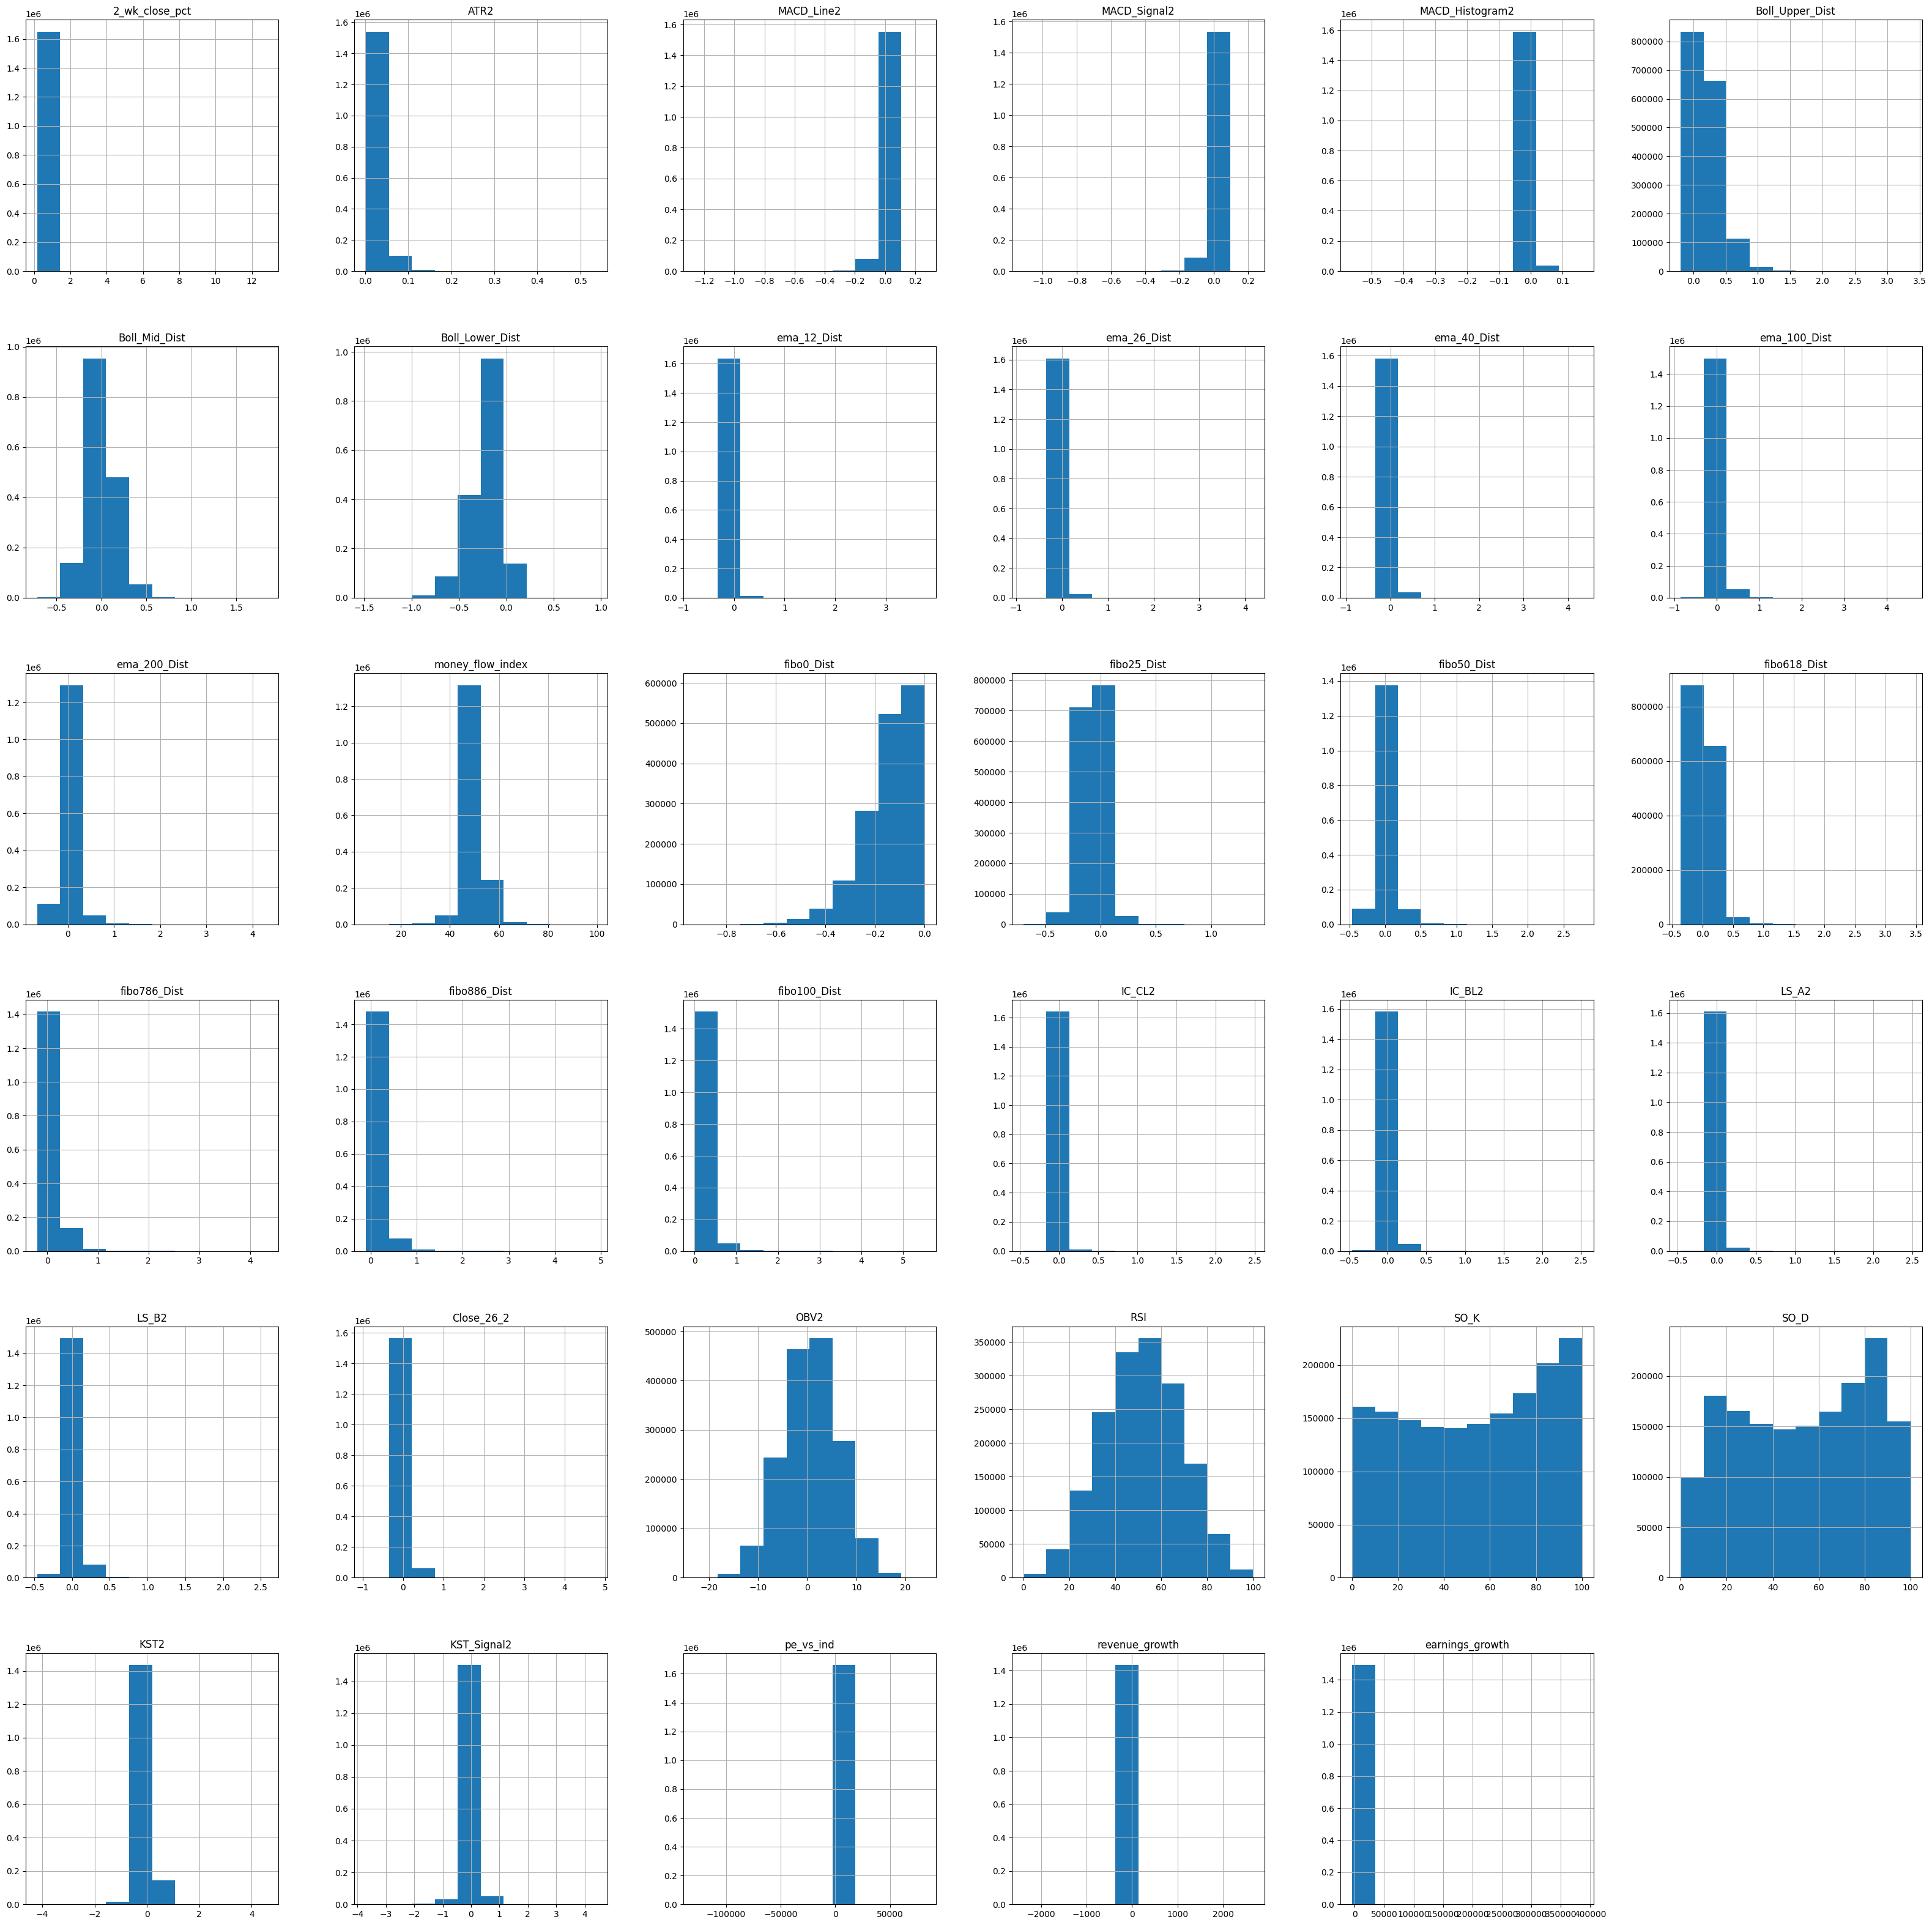

In [54]:
#hist = final_data_precursor['MACD_Line2'].hist(bins=10)

fig = plt.figure(figsize = (40,40))
ax = fig.gca()
hist_table.hist(ax = ax)

#### We see a lot of tall bars, this is indicative of outliers which should be removed

In [55]:
final_data_precursor = final_data_precursor[final_data_precursor['2_wk_close_pct'] < (final_data_precursor['2_wk_close_pct'].mean() + (final_data_precursor['2_wk_close_pct'].std()*3))]
final_data_precursor = final_data_precursor[final_data_precursor['2_wk_close_pct'] > (final_data_precursor['2_wk_close_pct'].mean() - (final_data_precursor['2_wk_close_pct'].std()*3))]                                         

## Variable Outlier Removal

In [56]:

hist_table2 = hist_table.dropna().copy()
hist_table2 = hist_table2.drop(columns = ['Industry','Sector']).copy()
hist_table3 = hist_table2[(np.abs(stats.zscore(hist_table2)) < 3).all(axis=1)].copy()

/tmp/ipykernel_1121241/3285260031.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  hist_table3.hist(ax = ax)


array([[<Axes: title={'center': '2_wk_close_pct'}>,
        <Axes: title={'center': 'ATR2'}>,
        <Axes: title={'center': 'MACD_Line2'}>,
        <Axes: title={'center': 'MACD_Signal2'}>,
        <Axes: title={'center': 'MACD_Histogram2'}>,
        <Axes: title={'center': 'Boll_Upper_Dist'}>],
       [<Axes: title={'center': 'Boll_Mid_Dist'}>,
        <Axes: title={'center': 'Boll_Lower_Dist'}>,
        <Axes: title={'center': 'ema_12_Dist'}>,
        <Axes: title={'center': 'ema_26_Dist'}>,
        <Axes: title={'center': 'ema_40_Dist'}>,
        <Axes: title={'center': 'ema_100_Dist'}>],
       [<Axes: title={'center': 'ema_200_Dist'}>,
        <Axes: title={'center': 'money_flow_index'}>,
        <Axes: title={'center': 'fibo0_Dist'}>,
        <Axes: title={'center': 'fibo25_Dist'}>,
        <Axes: title={'center': 'fibo50_Dist'}>,
        <Axes: title={'center': 'fibo618_Dist'}>],
       [<Axes: title={'center': 'fibo786_Dist'}>,
        <Axes: title={'center': 'fibo886_Dist'}>

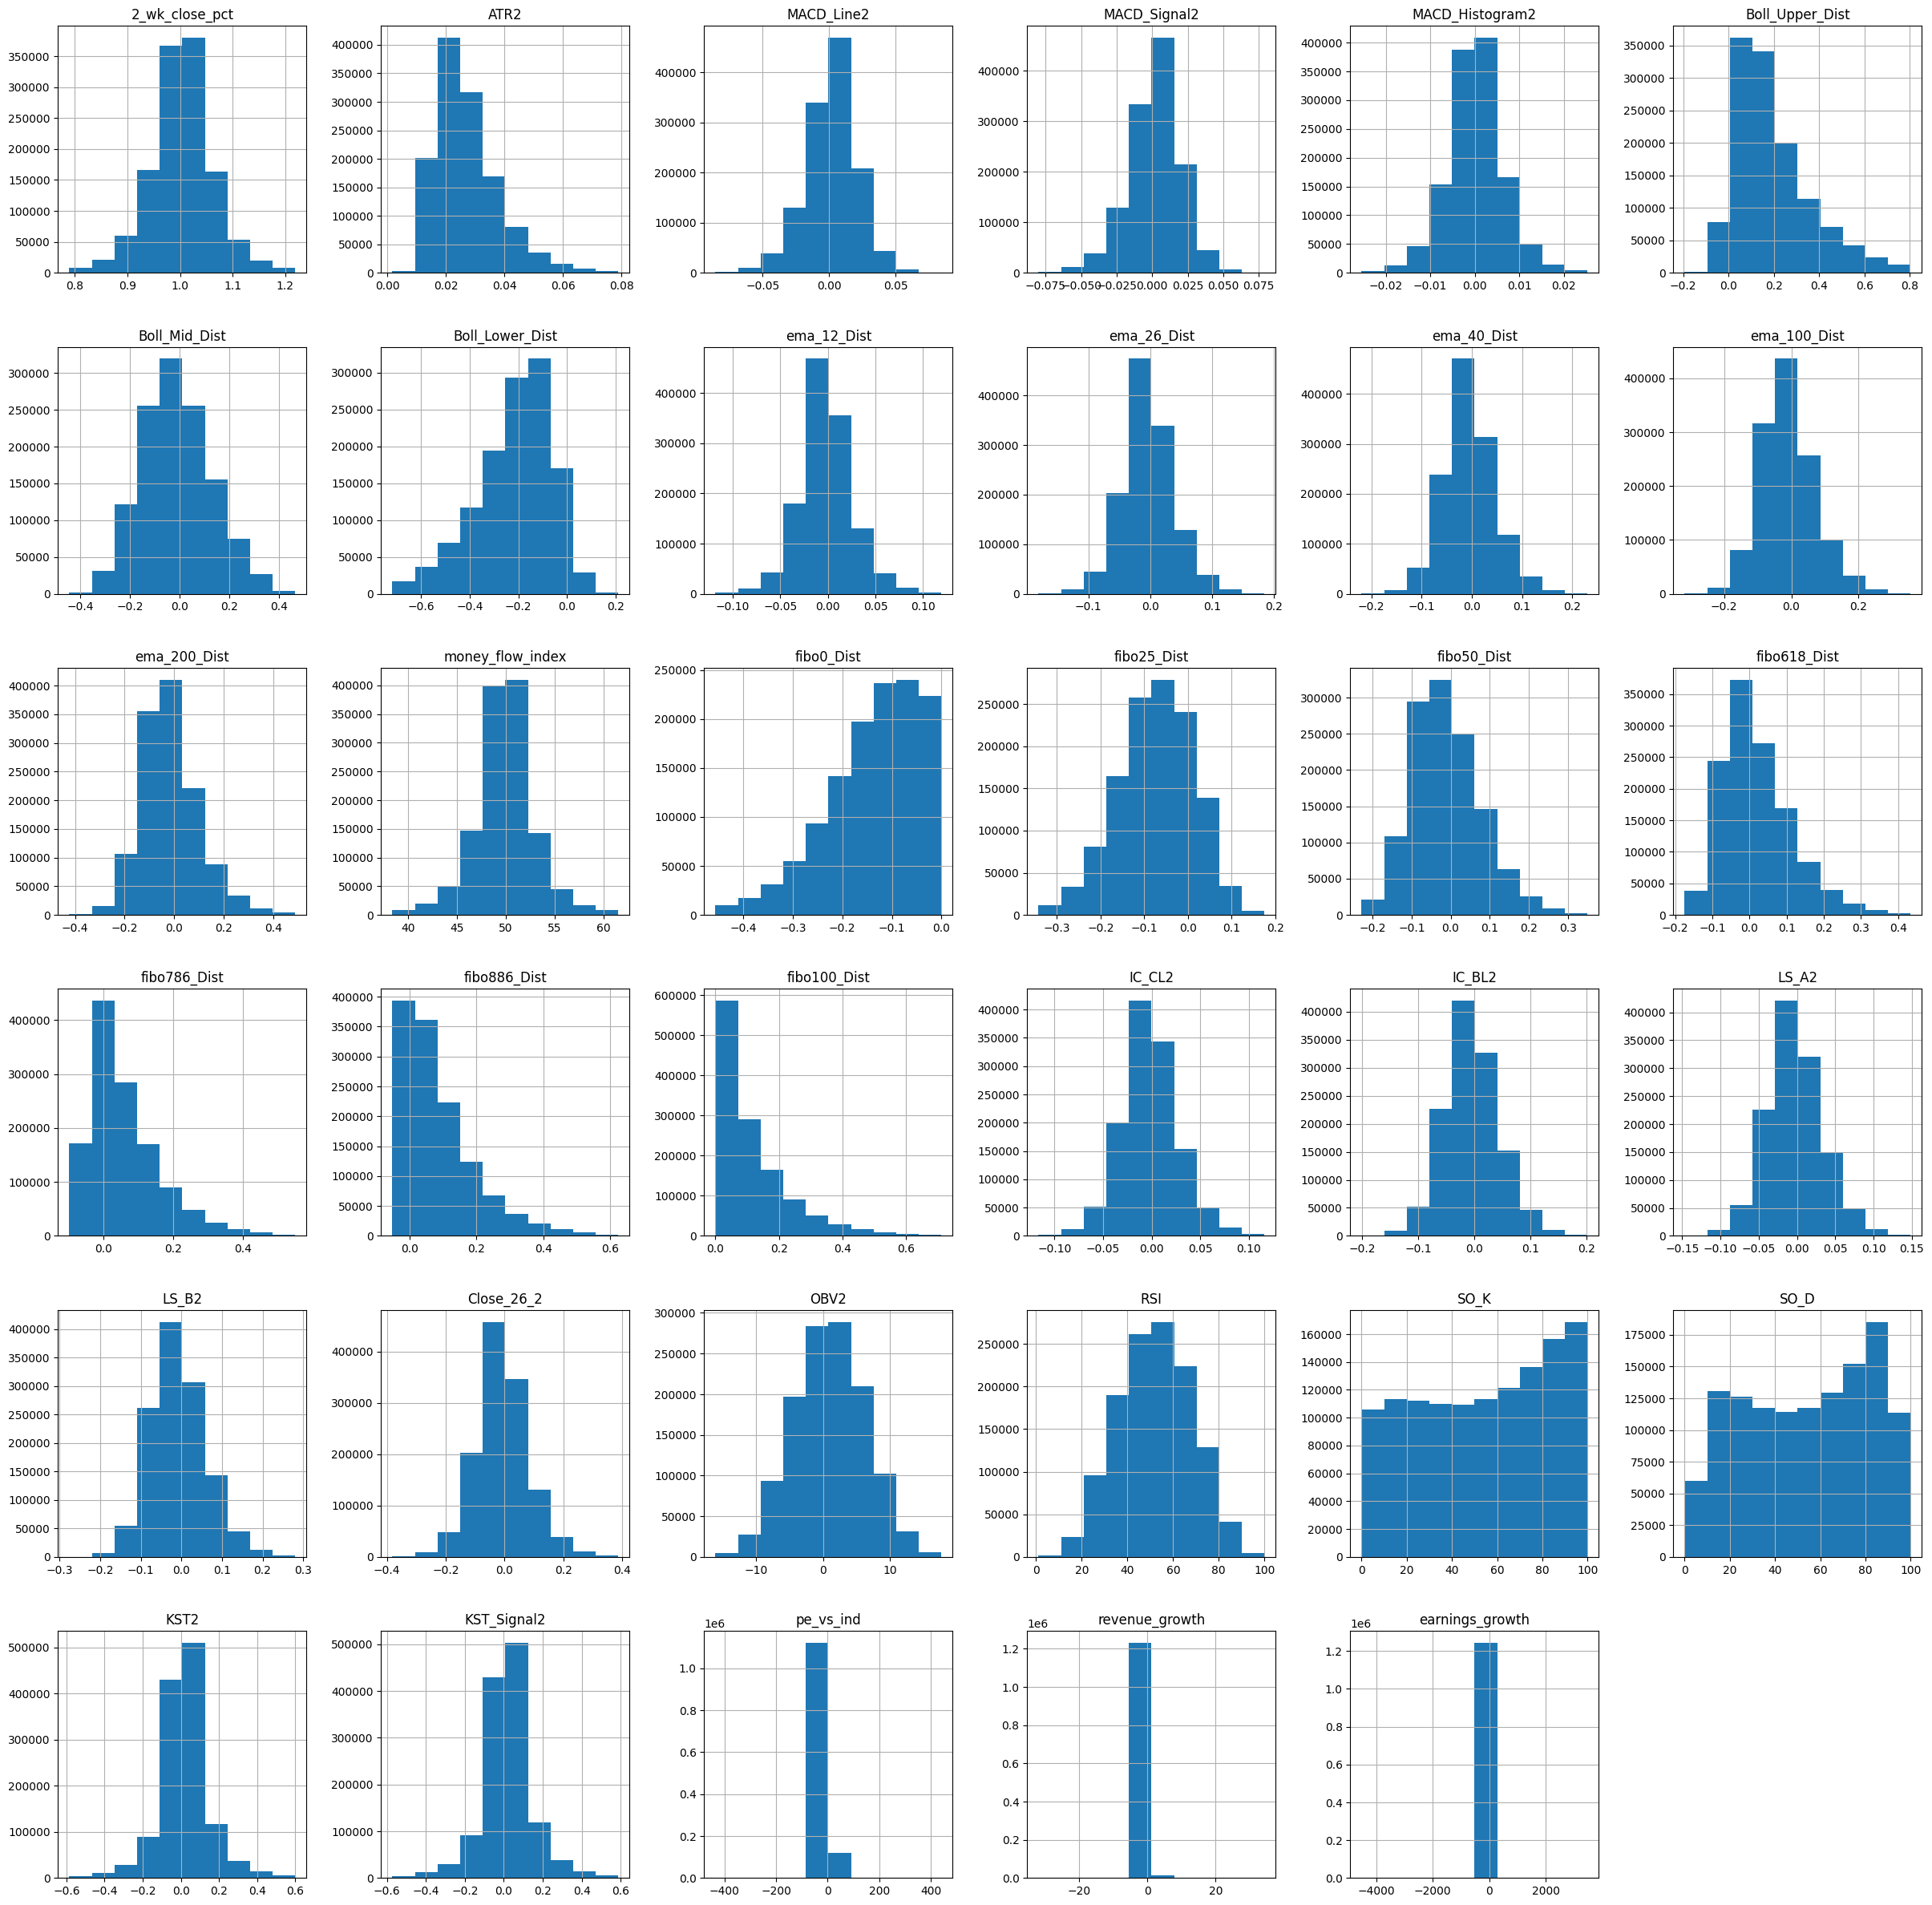

In [57]:
fig = plt.figure(figsize = (30,30))
ax = fig.gca()
hist_table3.hist(ax = ax)

#### This looks significantly better.  We can go one step further and leverage min/max scaling

In [58]:
final_data_precursor[final_data_precursor['earnings_growth'] > 100]

Unnamed: 0.2   open     high     low  close    volume  \
ticker date2                                                               
ABBV   2018-04-02       3248727  94.00  94.6400  90.300  91.46   7816500   
       2018-04-03       3249534  92.34  92.4600  88.220  90.59  10449200   
       2018-04-04       3250341  88.71  93.4100  88.630  92.94   8841700   
       2018-04-05       3251148  93.07  93.2700  91.650  92.21   7045000   
       2018-04-06       3251955  91.45  92.7700  88.790  89.78   6761200   
...                         ...    ...      ...     ...    ...       ...   
Z      2019-03-25        940847  35.44  36.3700  35.040  35.86   1648500   
       2019-03-26        941816  36.06  36.5100  34.980  35.43   2164300   
       2019-03-27        942785  35.73  36.6600  35.020  35.27   3348000   
       2019-03-28        943756  35.31  35.6284  34.180  34.26   2423500   
       2019-03-29        944728  34.67  35.1495  33.805  34.74   2981100   

                                  Report Date  earnings_share  \
ticker date2                                                    
ABBV   2018-04-02  2018-03-31 00:00:00.000000        1.749214   
       2018-04-03  2018-03-31 00:00:00.000000        1.749214   
       2018-04-04  2018-03-31 00:00:00.000000        1.749214   
       2018-04-05  2018-03-31 00:00:00.000000        1.749214   
       2018-04-06  2018-03-31 00:00:00.000000        1.749214   
...                                       ...             ...   
Z      2019-03-25  2018-12-31 00:00:00.000000       -0.479442   
       2019-03-26  2018-12-31 00:00:00.000000       -0.479442   
       2019-03-27  2018-12-31 00:00:00.000000       -0.479442   
       2019-03-28  2018-12-31 00:00:00.000000       -0.479442   
       2019-03-29  2018-12-31 00:00:00.000000       -0.479442   

                               Industry       Sector  ...  Close_26_2  \
ticker date2                                          ...               
ABBV   2018-04-02    Drug Manufacturers   Healthcare  ...    0.285371   
       2018-04-03    Drug Manufacturers   Healthcare  ...    0.310851   
       2018-04-04    Drug Manufacturers   Healthcare  ...    0.307725   
       2018-04-05    Drug Manufacturers   Healthcare  ...    0.282507   
       2018-04-06    Drug Manufacturers   Healthcare  ...    0.290154   
...                                 ...          ...  ...         ...   
Z      2019-03-25  Real Estate Services  Real Estate  ...    0.003067   
       2019-03-26  Real Estate Services  Real Estate  ...    0.049393   
       2019-03-27  Real Estate Services  Real Estate  ...    0.027219   
       2019-03-28  Real Estate Services  Real Estate  ...    0.016637   
       2019-03-29  Real Estate Services  Real Estate  ...    0.008636   

                          OBV     vol26_avg       OBV2  price_earnings  \
ticker date2                                                             
ABBV   2018-04-02 -67329600.0  7.571646e+06  -8.892333       52.286331   
       2018-04-03 -82464500.0  7.793319e+06 -10.581435       51.788965   
       2018-04-04 -78096200.0  7.961331e+06  -9.809440       53.132425   
       2018-04-05 -80386900.0  8.049435e+06  -9.986652       52.715095   
       2018-04-06 -80488200.0  8.053331e+06  -9.994399       51.325900   
...                       ...           ...        ...             ...   
Z      2019-03-25 -13115900.0  4.069035e+06  -3.223344      -74.795277   
       2019-03-26 -18481600.0  4.029146e+06  -4.586977      -73.898401   
       2019-03-27 -18677300.0  4.036673e+06  -4.626904      -73.564680   
       2019-03-28 -15966000.0  3.932392e+06  -4.060124      -71.458065   
       2019-03-29 -19669900.0  3.789935e+06  -5.190037      -72.459228   

                  industry_price_earnings pe_vs_ind  2_wk_close  \
ticker date2                                                      
ABBV   2018-04-02               94.646701  0.552437       92.60   
       2018-04-03               95.453973  0.542554       93.59   
   

In [59]:
hist_table3['revenue_growth'].max()

34.30573248407644

## Feature Rescaling

In [60]:
final_data_precursor['2_wk_close_pct_scaled'] = (final_data_precursor['2_wk_close_pct'] - 
                                       final_data_precursor['2_wk_close_pct'].min()) / (final_data_precursor['2_wk_close_pct'].max() - final_data_precursor['2_wk_close_pct'].min())

final_data_precursor['ATR2_scaled'] = (final_data_precursor['ATR2'] - 
                                       final_data_precursor['ATR2'].min()) / (final_data_precursor['ATR2'].max() - final_data_precursor['ATR2'].min())

final_data_precursor['MACD_Line_scaled'] = (final_data_precursor['MACD_Line2'] - 
                                       final_data_precursor['MACD_Line2'].min()) / (final_data_precursor['MACD_Line2'].max() - final_data_precursor['MACD_Line2'].min())

final_data_precursor['MACD_Signal_scaled'] = (final_data_precursor['MACD_Signal2'] - 
                                       final_data_precursor['MACD_Signal2'].min()) / (final_data_precursor['MACD_Signal2'].max() - final_data_precursor['MACD_Signal2'].min())

final_data_precursor['MACD_Histogram_scaled'] = (final_data_precursor['MACD_Histogram2'] - 
                                       final_data_precursor['MACD_Histogram2'].min()) / (final_data_precursor['MACD_Histogram2'].max() - final_data_precursor['MACD_Histogram2'].min())

final_data_precursor['Boll_Upper_scaled'] = (final_data_precursor['Boll_Upper_Dist'] - 
                                       final_data_precursor['Boll_Upper_Dist'].min()) / (final_data_precursor['Boll_Upper_Dist'].max() - final_data_precursor['Boll_Upper_Dist'].min())

final_data_precursor['Boll_Mid_scaled'] = (final_data_precursor['Boll_Mid_Dist'] - 
                                       final_data_precursor['Boll_Mid_Dist'].min()) / (final_data_precursor['Boll_Mid_Dist'].max() - final_data_precursor['Boll_Mid_Dist'].min())

final_data_precursor['Boll_Lower_scaled'] = (final_data_precursor['Boll_Lower_Dist'] - 
                                       final_data_precursor['Boll_Lower_Dist'].min()) / (final_data_precursor['Boll_Lower_Dist'].max() - final_data_precursor['Boll_Lower_Dist'].min())

final_data_precursor['ema_12_Dist_scaled'] = (final_data_precursor['ema_12_Dist'] - 
                                       final_data_precursor['ema_12_Dist'].min()) / (final_data_precursor['ema_12_Dist'].max() - final_data_precursor['ema_12_Dist'].min())

final_data_precursor['ema_26_Dist_scaled'] = (final_data_precursor['ema_26_Dist'] - 
                                       final_data_precursor['ema_26_Dist'].min()) / (final_data_precursor['ema_26_Dist'].max() - final_data_precursor['ema_26_Dist'].min())

final_data_precursor['ema_40_Dist_scaled'] = (final_data_precursor['ema_40_Dist'] - 
                                       final_data_precursor['ema_40_Dist'].min()) / (final_data_precursor['ema_40_Dist'].max() - final_data_precursor['ema_40_Dist'].min())

final_data_precursor['ema_100_Dist_scaled'] = (final_data_precursor['ema_100_Dist'] - 
                                       final_data_precursor['ema_100_Dist'].min()) / (final_data_precursor['ema_100_Dist'].max() - final_data_precursor['ema_100_Dist'].min())

final_data_precursor['ema_200_Dist_scaled'] = (final_data_precursor['ema_200_Dist'] - 
                                       final_data_precursor['ema_200_Dist'].min()) / (final_data_precursor['ema_200_Dist'].max() - final_data_precursor['ema_200_Dist'].min())

final_data_precursor['money_flow_index_scaled'] = (final_data_precursor['money_flow_index'] - 
                                       final_data_precursor['money_flow_index'].min()) / (final_data_precursor['money_flow_index'].max() - final_data_precursor['money_flow_index'].min())

final_data_precursor['fibo0_Dist_scaled'] = (final_data_precursor['fibo0_Dist'] - 
                                       final_data_precursor['fibo0_Dist'].min()) / (final_data_precursor['fibo0_Dist'].max() - final_data_precursor['fibo0_Dist'].min())

final_data_precursor['fibo25_Dist_scaled'] = (final_data_precursor['fibo25_Dist'] - 
                                       final_data_precursor['fibo25_Dist'].min()) / (final_data_precursor['fibo25_Dist'].max() - final_data_precursor['fibo25_Dist'].min())

final_data_precursor['fibo50_Dist_scaled'] = (final_data_precursor['fibo50_Dist'] - 
                                       final_data_precursor['fibo50_Dist'].min()) / (final_data_precursor['fibo50_Dist'].max() - final_data_precursor['fibo50_Dist'].min())

final_data_precursor['fibo618_Dist_scaled'] = (final_data_precursor['fibo618_Dist'] - 
                                       final_data_precursor['fibo618_Dist'].min()) / (final_data_precursor['fibo618_Dist'].max() - final_data_precursor['fibo618_Dist'].min())

final_data_precursor['fibo786_Dist_scaled'] = (final_data_precursor['fibo786_Dist'] - 
                                       final_data_precursor['fibo786_Dist'].min()) / (final_data_precursor['fibo786_Dist'].max() - final_data_precursor['fibo786_Dist'].min())

final_data_precursor['fibo886_Dist_scaled'] = (final_data_precursor['fibo886_Dist'] - 
                                       final_data_precursor['fibo886_Dist'].min()) / (final_data_precursor['fibo886_Dist'].max() - final_data_precursor['fibo886_Dist'].min())

final_data_precursor['fibo100_Dist_scaled'] = (final_data_precursor['fibo100_Dist'] - 
                                       final_data_precursor['fibo100_Dist'].min()) / (final_data_precursor['fibo100_Dist'].max() - final_data_precursor['fibo100_Dist'].min())

final_data_precursor['IC_CL2_scaled'] = (final_data_precursor['IC_CL2'] - 
                                       final_data_precursor['IC_CL2'].min()) / (final_data_precursor['IC_CL2'].max() - final_data_precursor['IC_CL2'].min())


final_data_precursor['IC_BL2_scaled'] = (final_data_precursor['IC_BL2'] - 
                                       final_data_precursor['IC_BL2'].min()) / (final_data_precursor['IC_BL2'].max() - final_data_precursor['IC_BL2'].min())


final_data_precursor['LS_A2_scaled'] = (final_data_precursor['LS_A2'] - 
                                       final_data_precursor['LS_A2'].min()) / (final_data_precursor['LS_A2'].max() - final_data_precursor['LS_A2'].min())


final_data_precursor['LS_B2_scaled'] = (final_data_precursor['LS_B2'] - 
                                       final_data_precursor['LS_B2'].min()) / (final_data_precursor['LS_B2'].max() - final_data_precursor['LS_B2'].min())

final_data_precursor['Close_26_2_scaled'] = (final_data_precursor['Close_26_2'] - 
                                       final_data_precursor['Close_26_2'].min()) / (final_data_precursor['Close_26_2'].max() - final_data_precursor['Close_26_2'].min())

final_data_precursor['OBV2_scaled'] = (final_data_precursor['OBV2'] - 
                                       final_data_precursor['OBV2'].min()) / (final_data_precursor['OBV2'].max() - final_data_precursor['OBV2'].min())


final_data_precursor['RSI_scaled'] = (final_data_precursor['RSI'] - 
                                       final_data_precursor['RSI'].min()) / (final_data_precursor['RSI'].max() - final_data_precursor['RSI'].min())

final_data_precursor['SO_K_scaled'] = (final_data_precursor['SO_K'] - 
                                       final_data_precursor['SO_K'].min()) / (final_data_precursor['SO_K'].max() - final_data_precursor['SO_K'].min())

final_data_precursor['SO_D_scaled'] = (final_data_precursor['SO_D'] - 
                                       final_data_precursor['SO_D'].min()) / (final_data_precursor['SO_D'].max() - final_data_precursor['SO_D'].min())

final_data_precursor['KST_scaled'] = (final_data_precursor['KST2'] - 
                                       final_data_precursor['KST2'].min()) / (final_data_precursor['KST2'].max() - final_data_precursor['KST2'].min())

final_data_precursor['KST_Signal_scaled'] = (final_data_precursor['KST_Signal2'] - 
                                       final_data_precursor['KST_Signal2'].min()) / (final_data_precursor['KST_Signal2'].max() - final_data_precursor['KST_Signal2'].min())

In [61]:
final_data_precursor.replace([np.inf, -np.inf], np.nan, inplace=True)
final_data_precursor = final_data_precursor.dropna()

In [62]:
final_data_precursor

Unnamed: 0.2   open   high      low  close   volume  \
ticker date2                                                             
A      2015-05-01       2690468  41.41  41.93  41.2400  41.83  1880100   
       2015-05-04       2691131  41.88  42.08  41.7000  41.94  1073800   
       2015-05-05       2691794  41.72  41.85  41.4600  41.59  1254800   
       2015-05-06       2692457  41.86  41.86  41.3600  41.59   934600   
       2015-05-07       2693120  41.59  41.85  41.3100  41.80   999600   
...                         ...    ...    ...      ...    ...      ...   
ZUMZ   2023-09-28       2526386  17.43  17.88  17.4200  17.69   273100   
       2023-09-29       2528036  17.89  17.92  17.6000  17.80   228300   
       2023-10-02       2529693  17.74  17.78  17.1718  17.31   292400   
       2023-10-03       2531349  17.24  17.25  17.0200  17.06   205400   
       2023-10-04       2533010  17.11  17.57  16.9850  17.42   398400   

                                  Report Date  earnings_share  \
ticker date2                                                    
A      2015-05-01  2015-04-30 00:00:00.000000        0.260479   
       2015-05-04  2015-04-30 00:00:00.000000        0.260479   
       2015-05-05  2015-04-30 00:00:00.000000        0.260479   
       2015-05-06  2015-04-30 00:00:00.000000        0.260479   
       2015-05-07  2015-04-30 00:00:00.000000        0.260479   
...                                       ...             ...   
ZUMZ   2023-09-28  2023-07-31 00:00:00.000000       -0.440630   
       2023-09-29  2023-07-31 00:00:00.000000       -0.440630   
       2023-10-02  2023-07-31 00:00:00.000000       -0.440630   
       2023-10-03  2023-07-31 00:00:00.000000       -0.440630   
       2023-10-04  2023-07-31 00:00:00.000000       -0.440630   

                                         Industry             Sector  ...  \
ticker date2                                                          ...   
A      2015-05-01  Medical Diagnostics & Research         Healthcare  ...   
       2015-05-04  Medical Diagnostics & Research         Healthcare  ...   
       2015-05-05  Medical Diagnostics & Research         Healthcare  ...   
       2015-05-06  Medical Diagnostics & Research         Healthcare  ...   
       2015-05-07  Medical Diagnostics & Research         Healthcare  ...   
...                                           ...                ...  ...   
ZUMZ   2023-09-28    Retail - Apparel & Specialty  Consumer Cyclical  ...   
       2023-09-29    Retail - Apparel & Specialty  Consumer Cyclical  ...   
       2023-10-02    Retail - Apparel & Specialty  Consumer Cyclical  ...   
       2023-10-03    Retail - Apparel & Specialty  Consumer Cyclical  ...   
       2023-10-04    Retail - Apparel & Specialty  Consumer Cyclical  ...   

                   IC_BL2_scaled  LS_A2_scaled  LS_B2_scaled  \
ticker date2                                                   
A      2015-05-01       0.156307      0.158637      0.156307   
       2015-05-04       0.156264      0.156863      0.155422   
       2015-05-05       0.159667      0.160023      0.158253   
       2015-05-06       0.159667      0.159921      0.158253   
       2015-05-07       0.157956      0.158109      0.156549   
...                          ...           ...           ...   
ZUMZ   2023-09-28       0.155007      0.149738      0.155102   
       2023-09-29       0.152931      0.150112      0.153025   
       2023-10-02       0.162381      0.161651      0.162478   
       2023-10-03       0.167412      0.167028      0.167510   
       2023-10-04       0.160213      0.159734      0.160310   

                   Close_26_2_scaled  OBV2_scaled RSI_scaled SO_K_scaled  \
ticker date2                                                               
A      2015-05-01           0.157774     0.379152   0.333333    0.293878   
       2015-05-04           0.156864     0.404954   0.347709    0.338776   
       2015-05-05           0.160030     0.371045   0.261333    0.20083

In [63]:
final_data_precursor['earnings_decile'] = pd.qcut(final_data_precursor['earnings_growth'], 10, labels=False)
final_data_precursor['revenue_decile'] = pd.qcut(final_data_precursor['revenue_growth'], 10, labels=False)
final_data_precursor['pe_vs_ind_decile'] = pd.qcut(final_data_precursor['pe_vs_ind'], 10, labels=False)

# Signal Transformation to Indicators

## EMA Crossover

In [64]:

final_data_precursor['ema_12v26'] = np.where(final_data_precursor['ema_12'] > final_data_precursor['ema_26'],1,-1)
final_data_precursor['ema_26v40'] = np.where(final_data_precursor['ema_26'] > final_data_precursor['ema_40'],1,-1)
final_data_precursor['ema_40v100'] = np.where(final_data_precursor['ema_40'] > final_data_precursor['ema_100'],1,-1)
final_data_precursor['ema_100v200'] = np.where(final_data_precursor['ema_100'] > final_data_precursor['ema_200'],1,-1)

final_data_precursor['ema_12v26_roll5'] = final_data_precursor['ema_12v26'].groupby(level=["ticker"]).rolling(min_periods=5, window=5).sum().droplevel(0,axis = 0)
final_data_precursor['ema_12v26_roll10'] = final_data_precursor['ema_12v26'].groupby(level=["ticker"]).rolling(min_periods=10, window=10).sum().droplevel(0,axis = 0)

final_data_precursor['ema_26v40_roll5'] = final_data_precursor['ema_26v40'].groupby(level=["ticker"]).rolling(min_periods=5, window=5).sum().droplevel(0,axis = 0)
final_data_precursor['ema_26v40_roll10'] = final_data_precursor['ema_26v40'].groupby(level=["ticker"]).rolling(min_periods=10, window=10).sum().droplevel(0,axis = 0)

final_data_precursor['ema_40v100_roll5'] = final_data_precursor['ema_40v100'].groupby(level=["ticker"]).rolling(min_periods=5, window=5).sum().droplevel(0,axis = 0)
final_data_precursor['ema_40v100_roll10'] = final_data_precursor['ema_40v100'].groupby(level=["ticker"]).rolling(min_periods=10, window=10).sum().droplevel(0,axis = 0)

final_data_precursor['ema_100v200_roll5'] = final_data_precursor['ema_100v200'].groupby(level=["ticker"]).rolling(min_periods=5, window=5).sum().droplevel(0,axis = 0)
final_data_precursor['ema_100v200_roll10'] = final_data_precursor['ema_100v200'].groupby(level=["ticker"]).rolling(min_periods=10, window=10).sum().droplevel(0,axis = 0)


final_data_precursor['ema_12v26_cross_up_flg'] = np.where((final_data_precursor['ema_12v26_roll5'] > 0) & (final_data_precursor['ema_12v26_roll5'] > final_data_precursor['ema_12v26_roll10']),1,0)
final_data_precursor['ema_12v26_cross_dn_flg'] = np.where((final_data_precursor['ema_12v26_roll5'] < 0) & (final_data_precursor['ema_12v26_roll5'] < final_data_precursor['ema_12v26_roll10']),1,0)

final_data_precursor['ema_26v40_cross_up_flg'] = np.where((final_data_precursor['ema_26v40_roll5'] > 0) & (final_data_precursor['ema_26v40_roll5'] > final_data_precursor['ema_26v40_roll10']),1,0)
final_data_precursor['ema_26v40_cross_dn_flg'] = np.where((final_data_precursor['ema_26v40_roll5'] < 0) & (final_data_precursor['ema_26v40_roll5'] < final_data_precursor['ema_26v40_roll10']),1,0)

final_data_precursor['ema_40v100_cross_up_flg'] = np.where((final_data_precursor['ema_40v100_roll5'] > 0) & (final_data_precursor['ema_40v100_roll5'] > final_data_precursor['ema_40v100_roll10']),1,0)
final_data_precursor['ema_40v100_cross_dn_flg'] = np.where((final_data_precursor['ema_40v100_roll5'] < 0) & (final_data_precursor['ema_40v100_roll5'] < final_data_precursor['ema_40v100_roll10']),1,0)

final_data_precursor['ema_100v200_cross_up_flg'] = np.where((final_data_precursor['ema_100v200_roll5'] > 0) & (final_data_precursor['ema_100v200_roll5'] > final_data_precursor['ema_100v200_roll10']),1,0)
final_data_precursor['ema_100v200_cross_dn_flg'] = np.where((final_data_precursor['ema_100v200_roll5'] < 0) & (final_data_precursor['ema_100v200_roll5'] < final_data_precursor['ema_100v200_roll10']),1,0)


final_data_precursor = final_data_precursor.drop(columns = ['ema_12v26','ema_26v40', 'ema_40v100','ema_100v200', \
                                                           'ema_12v26_roll5','ema_12v26_roll10' \
                                                           ,'ema_26v40_roll5','ema_26v40_roll10' \
                                                           ,'ema_40v100_roll5','ema_40v100_roll10' \
                                                           ,'ema_100v200_roll5','ema_100v200_roll10'])

# Data Modelling

## Close Ranking

In [65]:
final_data_precursor.replace([np.inf, -np.inf], np.nan, inplace=True)
final_data = final_data_precursor.dropna()
final_data = final_data[['2_wk_close_pct_scaled','ATR2_scaled','MACD_Line_scaled','MACD_Signal_scaled' \
                                        ,'MACD_Histogram_scaled','Boll_Upper_scaled','Boll_Mid_scaled','Boll_Lower_scaled' \
                                        ,'ema_12_Dist_scaled','ema_26_Dist_scaled','ema_40_Dist_scaled','ema_100_Dist_scaled' \
                                        ,'ema_200_Dist_scaled','money_flow_index_scaled','fibo0_Dist_scaled','fibo25_Dist_scaled' \
                                        ,'fibo50_Dist_scaled','fibo618_Dist_scaled','fibo786_Dist_scaled','fibo886_Dist_scaled' \
                                        ,'fibo100_Dist_scaled','IC_CL2_scaled','IC_BL2_scaled','LS_A2_scaled' \
                                        ,'LS_B2_scaled','Close_26_2_scaled','OBV2_scaled','RSI_scaled' \
                                        ,'SO_K_scaled','SO_D_scaled','KST_scaled','KST_Signal_scaled','pe_vs_ind_decile' \
                                        ,'revenue_decile', 'earnings_decile','earnings_1wk', 'earnings_2wk', 'earnings_4wk','earnings_8wk', 'Industry','Sector'
                                       ]]



#### Remove entries where earnings are within decision window as earnings are unpredicable

In [66]:
hist_table

2_wk_close_pct      ATR2  MACD_Line2  MACD_Signal2  \
ticker date2                                                            
A      2014-05-01        1.000367       NaN         NaN           NaN   
       2014-05-02        1.008984       NaN         NaN           NaN   
       2014-05-05        0.993494       NaN         NaN           NaN   
       2014-05-06        0.987275       NaN         NaN           NaN   
       2014-05-07        0.999273       NaN         NaN           NaN   
...                           ...       ...         ...           ...   
ZUMZ   2023-10-12             NaN  0.035620   -0.014437     -0.012516   
       2023-10-13             NaN  0.037626   -0.020234     -0.014497   
       2023-10-16             NaN  0.037105   -0.017585     -0.014392   
       2023-10-17             NaN  0.037205   -0.011790     -0.013332   
       2023-10-18             NaN  0.038093   -0.010046     -0.012953   

                   MACD_Histogram2  Boll_Upper_Dist  Boll_Mid_Dist  \
ticker date2                                                         
A      2014-05-01              NaN              NaN            NaN   
       2014-05-02              NaN              NaN            NaN   
       2014-05-05              NaN              NaN            NaN   
       2014-05-06              NaN              NaN            NaN   
       2014-05-07              NaN              NaN            NaN   
...                            ...              ...            ...   
ZUMZ   2023-10-12        -0.001921         0.176696       0.079106   
       2023-10-13        -0.005737         0.290700       0.165666   
       2023-10-16        -0.003193         0.135955       0.031743   
       2023-10-17         0.001542         0.048837      -0.050540   
       2023-10-18         0.002907         0.092068      -0.007479   

                   Boll_Lower_Dist  ema_12_Dist  ema_26_Dist  ...        RSI  \
ticker date2                                                  ...              
A      2014-05-01              NaN          NaN          NaN  ...        NaN   
       2014-05-02              NaN          NaN          NaN  ...        NaN   
       2014-05-05              NaN          NaN          NaN  ...        NaN   
       2014-05-06              NaN          NaN          NaN  ...        NaN   
       2014-05-07              NaN          NaN          NaN  ...        NaN   
...                            ...          ...          ...  ...        ...   
ZUMZ   2023-10-12        -0.018483     0.033646     0.048084  ...  38.303342   
       2023-10-13         0.040632     0.066641     0.086875  ...  26.076555   
       2023-10-16        -0.072468     0.000181     0.017766  ...  44.583333   
       2023-10-17        -0.149917    -0.039555    -0.027765  ...  52.500000   
       2023-10-18        -0.107025    -0.012257    -0.002211  ...  46.100520   

                        SO_K       SO_D      KST2  KST_Signal2  pe_vs_ind  \
ticker date2                                                                
A      2014-05-01        NaN        NaN       NaN          NaN   1.000000   
       2014-05-02        NaN        NaN       NaN          NaN   1.000000   
       2014-05-05        NaN        NaN       NaN          NaN   1.000000   
       2014-05-06        NaN        NaN       NaN          NaN   1.000000   
       2014-05-07        NaN        NaN       NaN          NaN   1.000000   
...                      ...        ...       ...          ...        ...   
ZUMZ   2023-10-12  10.795455  31.542597 -0.261763    -0.260578  -0.669804   
       2023-10-13   5.833333  19.914187 -0.297583    -0.275312  -0.643258   
       2023-10-16  52.888889  23.172559 -0.281664    -0.261704  -0.672157   
       2023-10-17  89.777778  49.500000 -0.251433    -0.250807  -0.691620   
       2023-10-18  69.777778  70.814815 -0.257221    -0.256949  -0.885413   

                   revenue_growth  earnings_growth  \
ticker date2                                         
A      

In [67]:
final_data = final_data[final_data['earnings_8wk'] == 1]
final_data = final_data[final_data.index.isin(hist_table3.index)].copy()

## Determining Correllation

In [68]:
final_data

2_wk_close_pct_scaled  ATR2_scaled  MACD_Line_scaled  \
ticker date2                                                              
A      2015-05-01               0.468768     0.024598          0.828571   
       2015-05-04               0.494785     0.023732          0.828228   
       2015-05-05               0.500025     0.023926          0.827518   
       2015-05-06               0.513158     0.024526          0.826976   
       2015-05-07               0.485654     0.024419          0.826841   
...                                  ...          ...               ...   
ZUMZ   2023-09-18               0.571962     0.110074          0.810753   
       2023-09-19               0.472112     0.106766          0.811530   
       2023-09-20               0.425144     0.104556          0.814753   
       2023-09-21               0.404631     0.101195          0.815411   
       2023-09-22               0.380219     0.097171          0.816846   

                   MACD_Signal_scaled  MACD_Histogram_scaled  \
ticker date2                                                   
A      2015-05-01            0.832417               0.770494   
       2015-05-04            0.831635               0.771225   
       2015-05-05            0.830874               0.771140   
       2015-05-06            0.830123               0.771390   
       2015-05-07            0.829487               0.772288   
...                               ...                    ...   
ZUMZ   2023-09-18            0.817986               0.759697   
       2023-09-19            0.816545               0.764013   
       2023-09-20            0.816286               0.771301   
       2023-09-21            0.815592               0.773981   
       2023-09-22            0.815681               0.776843   

                   Boll_Upper_scaled  Boll_Mid_scaled  Boll_Lower_scaled  \
ticker date2                                                               
A      2015-05-01           0.137031         0.322504           0.585278   
       2015-05-04           0.132032         0.316051           0.578830   
       2015-05-05           0.148216         0.333582           0.592626   
       2015-05-06           0.162151         0.338664           0.583411   
       2015-05-07           0.152450         0.322888           0.564045   
...                              ...              ...                ...   
ZUMZ   2023-09-18           0.160037         0.340253           0.589780   
       2023-09-19           0.139187         0.314684           0.565722   
       2023-09-20           0.110049         0.282104           0.538743   
       2023-09-21           0.117213         0.294585           0.554795   
       2023-09-22           0.111670         0.287579           0.547958   

                   ema_12_Dist_scaled  ema_26_Dist_scaled  ...  \
ticker date2                                               ...   
A      2015-05-01            0.173003            0.170086  ...   
       2015-05-04            0.172199            0.169463  ...   
       2015-05-05            0.173591            0.170936  ...   
       2015-05-06            0.173190            0.170739  ...   
       2015-05-07            0.171903            0.169618  ...   
...                               ...                 ...  ...   
ZUMZ   2023-09-18            0.181603            0.183266  ...   
       2023-09-19            0.174544            0.176655  ...   
       2023-09-20            0.166268            0.168201  ...   
       2023-09-21            0.171224            0.172477  ...   
       2023-09-22            0.169684            0.170651  ...   

                   KST_Signal_scaled  pe_vs_ind_decile  revenue_decile  \
ticker date2                                                             
A      2015-05-01           0.444195                 2               2   
       2015-05-04           0.443842                 2               2   
       2015-05-05           0.443441                 2            

In [69]:
#final_data = final_data[(np.abs(stats.zscore(final_data)) < 3).all(axis=1)].copy()

In [70]:
Corr_Output = final_data.corr(method='pearson')

ValueError: could not convert string to float: 'Medical Diagnostics & Research'

In [ ]:
Corr_Output2 = Corr_Output[["2_wk_close_pct_scaled"]]

In [ ]:
sns.heatmap(Corr_Output2, 
            xticklabels=Corr_Output2.columns,
            yticklabels=Corr_Output.index,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [ ]:
sns.heatmap(Corr_Output, 
            xticklabels=Corr_Output.columns,
            yticklabels=Corr_Output.index,
            cmap='RdBu_r',
            annot=False,
            linewidth=0.5)

In [ ]:
Corr_Output.to_csv("F:/Stocks/corr_data.csv")

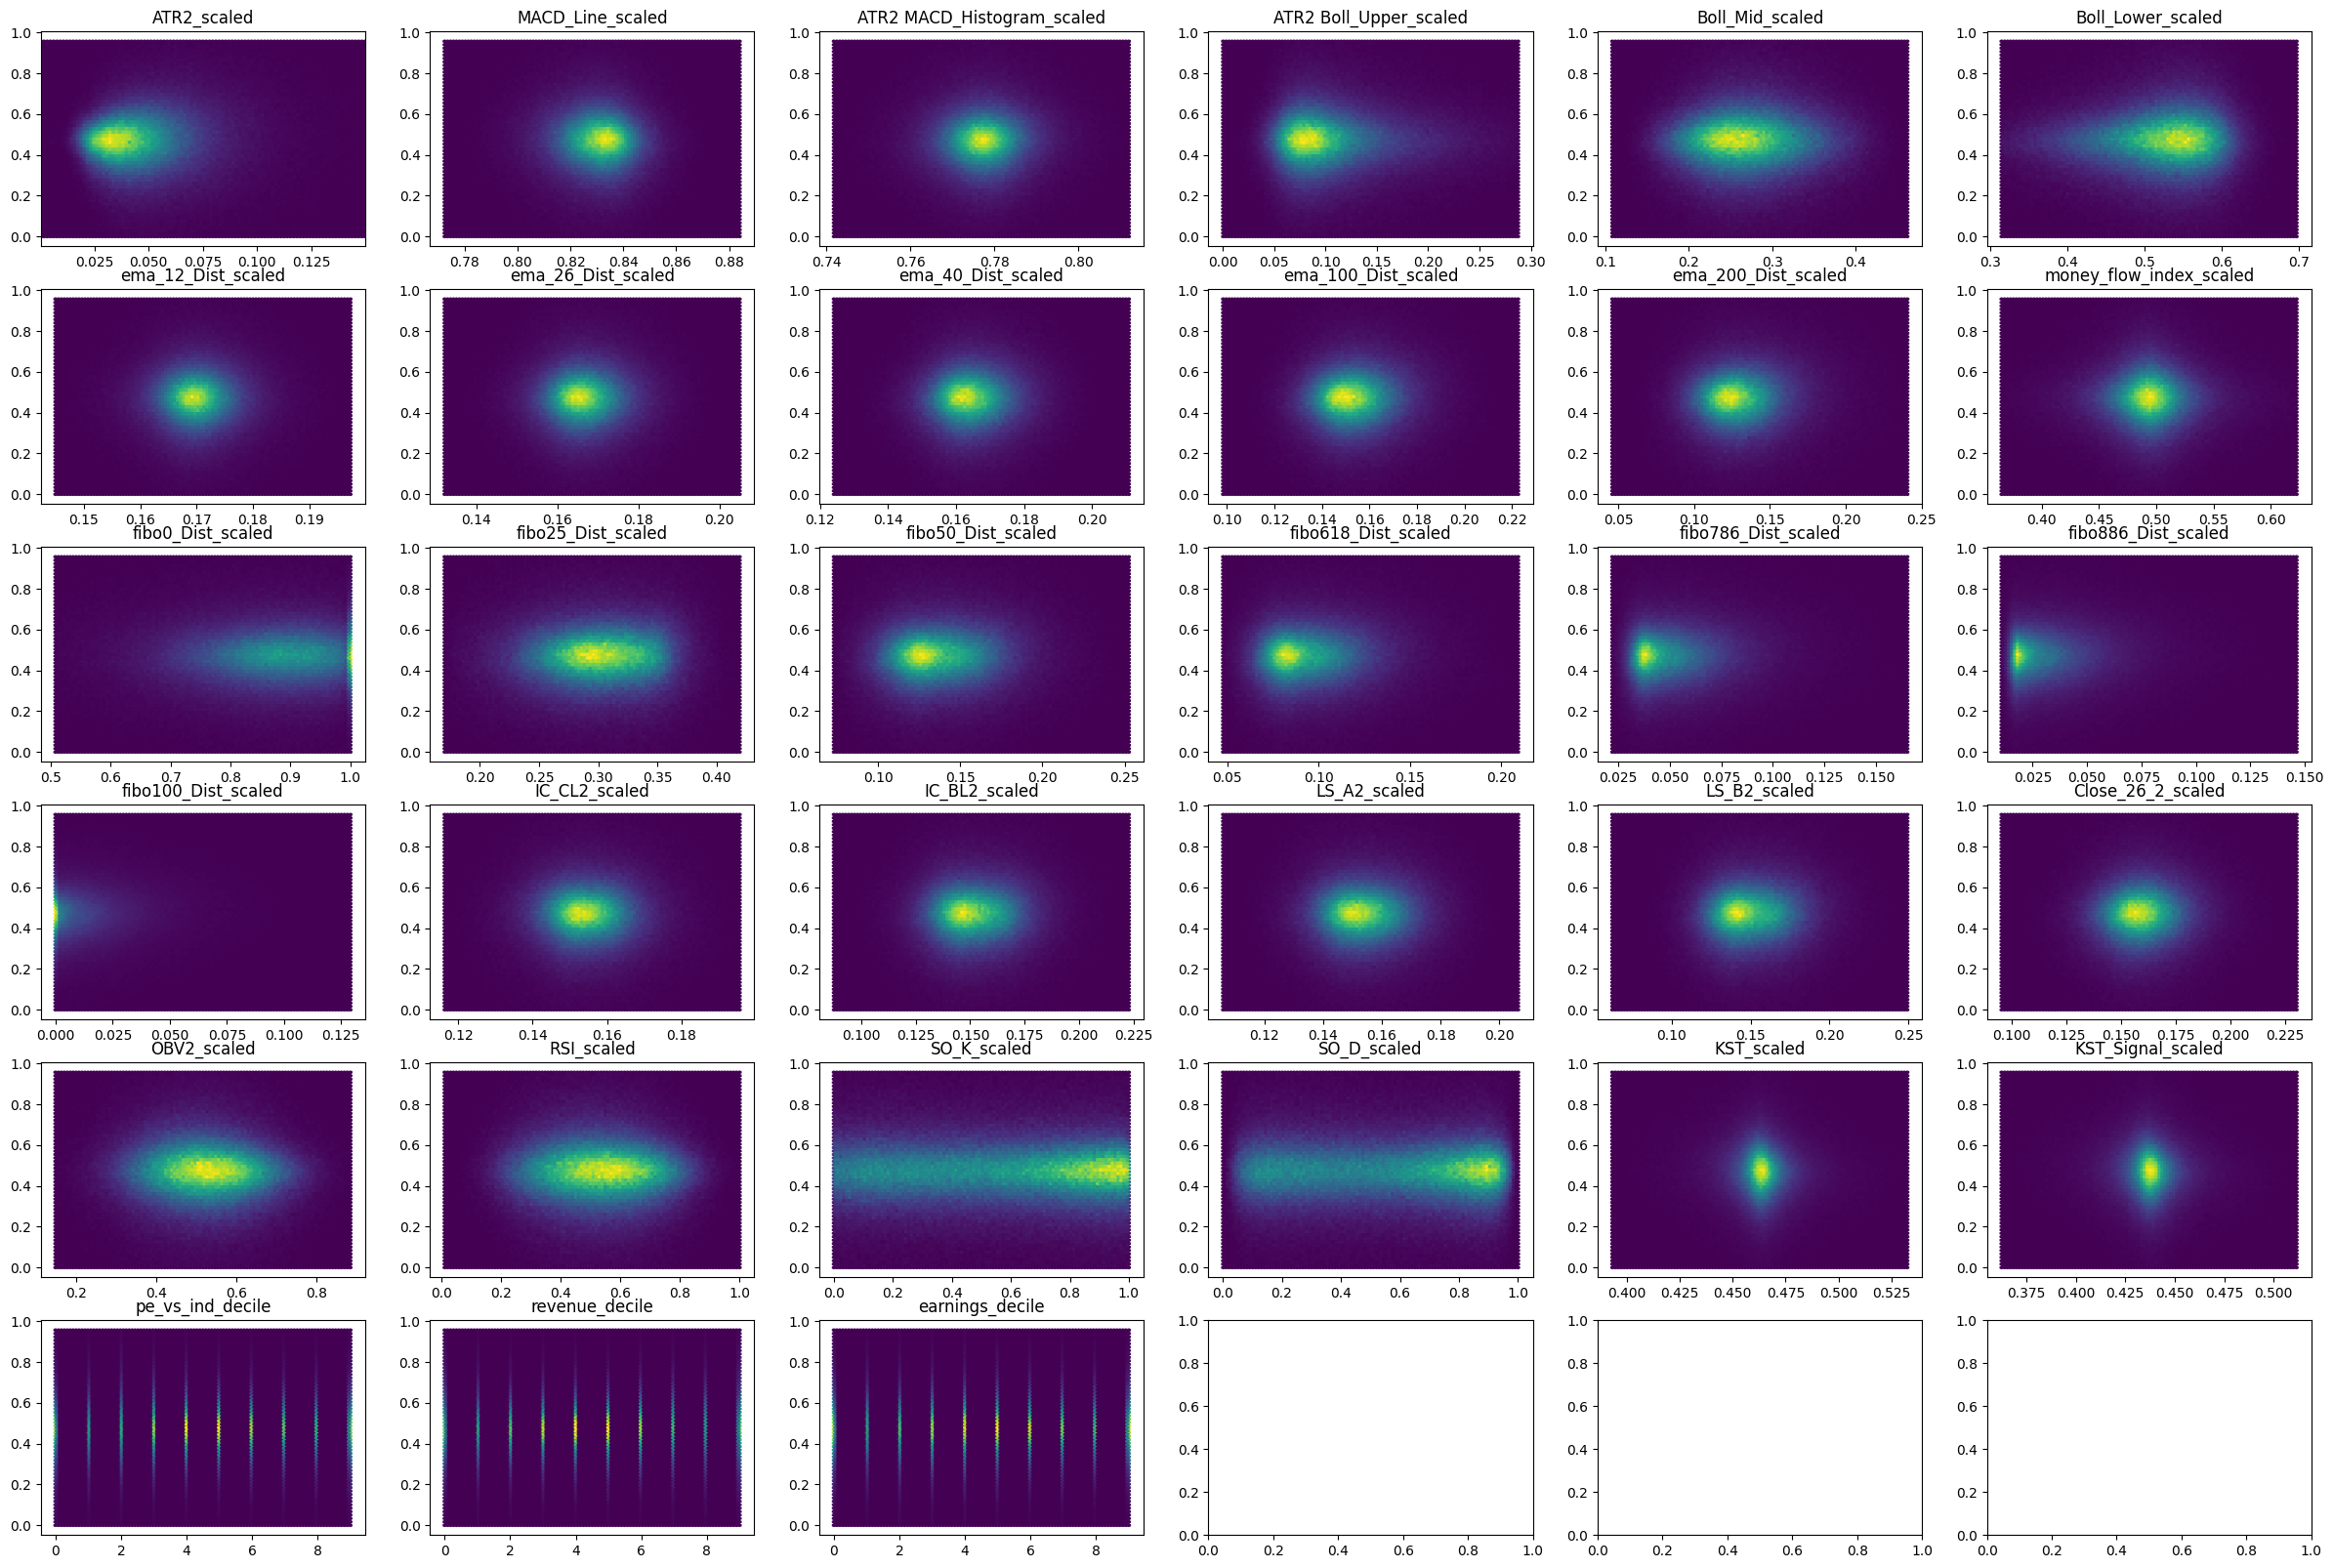

In [71]:
fig, axes = plt.subplots(6,6, figsize=(30,20))
axes[0, 0].hexbin(x=final_data['ATR2_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[0, 0].title.set_text('ATR2_scaled')
axes[0, 0].set_xlim([final_data['ATR2_scaled'].min(), final_data['ATR2_scaled'].max()])
axes[0, 1].hexbin(x=final_data['MACD_Line_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[0, 1].title.set_text('MACD_Line_scaled')
axes[0, 2].hexbin(x=final_data['MACD_Histogram_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[0, 2].title.set_text('ATR2 MACD_Histogram_scaled')
axes[0, 3].hexbin(x=final_data['Boll_Upper_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[0, 3].title.set_text('ATR2 Boll_Upper_scaled')
axes[0, 4].hexbin(x=final_data['Boll_Mid_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[0, 4].title.set_text('Boll_Mid_scaled')
axes[0, 5].hexbin(x=final_data['Boll_Lower_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[0, 5].title.set_text('Boll_Lower_scaled')
axes[1, 0].hexbin(x=final_data['ema_12_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[1, 0].title.set_text('ema_12_Dist_scaled')
axes[1, 1].hexbin(x=final_data['ema_26_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[1, 1].title.set_text('ema_26_Dist_scaled')
axes[1, 2].hexbin(x=final_data['ema_40_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[1, 2].title.set_text('ema_40_Dist_scaled')
axes[1, 3].hexbin(x=final_data['ema_100_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[1, 3].title.set_text('ema_100_Dist_scaled')
axes[1, 4].hexbin(x=final_data['ema_200_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[1, 4].title.set_text('ema_200_Dist_scaled')
axes[1, 5].hexbin(x=final_data['money_flow_index_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[1, 5].title.set_text('money_flow_index_scaled')
axes[2, 0].hexbin(x=final_data['fibo0_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[2, 0].title.set_text('fibo0_Dist_scaled')
axes[2, 1].hexbin(x=final_data['fibo25_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[2, 1].title.set_text('fibo25_Dist_scaled')
axes[2, 2].hexbin(x=final_data['fibo50_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[2, 2].title.set_text('fibo50_Dist_scaled')
axes[2, 3].hexbin(x=final_data['fibo618_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[2, 3].title.set_text('fibo618_Dist_scaled')
axes[2, 4].hexbin(x=final_data['fibo786_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[2, 4].title.set_text('fibo786_Dist_scaled')
axes[2, 5].hexbin(x=final_data['fibo886_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[2, 5].title.set_text('fibo886_Dist_scaled')
axes[3, 0].hexbin(x=final_data['fibo100_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[3, 0].title.set_text('fibo100_Dist_scaled')
axes[3, 1].hexbin(x=final_data['IC_CL2_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[3, 1].title.set_text('IC_CL2_scaled')
axes[3, 2].hexbin(x=final_data['IC_BL2_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[3, 2].title.set_text('IC_BL2_scaled')
axes[3, 3].hexbin(x=final_data['LS_A2_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[3, 3].title.set_text('LS_A2_scaled')
axes[3, 4].hexbin(x=final_data['LS_B2_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[3, 4].title.set_text('LS_B2_scaled')
axes[3, 5].hexbin(x=final_data['Close_26_2_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[3, 5].title.set_text('Close_26_2_scaled')
axes[4, 0].hexbin(x=final_data['OBV2_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[4, 0].title.set_text('OBV2_scaled')
axes[4, 1].hexbin(x=final_data['RSI_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[4, 1].title.set_text('RSI_scaled')
axes[4, 2].hexbin(x=final_data['SO_K_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[4, 2].title.set_text('SO_K_scaled')
axes[4, 3].hexbin(x=final_data['SO_D_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[4, 3].title.set_text('SO_D_scaled')
axes[4, 4].hexbin(x=final_data['KST_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[4, 4].title.set_text('KST_scaled')
axes[4, 5].hexbin(x=final_data['KST_Signal_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[4, 5].title.set_text('KST_Signal_scaled')
axes[5, 0].hexbin(x=final_data['pe_vs_ind_decile'], y=final_data['2_wk_close_pct_scaled'])
axes[5, 0].title.set_text('pe_vs_ind_decile')
axes[5, 1].hexbin(x=final_data['revenue_decile'], y=final_data['2_wk_close_pct_scaled'])
axes[5, 1].title.set_text('revenue_decile')
axes[5, 2].hexbin(x=final_data['earnings_decile'], y=final_data['2_wk_close_pct_scaled'])
axes[5, 2].title.set_text('earnings_decile')


#### Not seeing any positive or negative correlation with any distinct variables

## Test/Training Split

In [72]:
final_data.dtypes

2_wk_close_pct_scaled      float64
ATR2_scaled                float64
MACD_Line_scaled           float64
MACD_Signal_scaled         float64
MACD_Histogram_scaled      float64
Boll_Upper_scaled          float64
Boll_Mid_scaled            float64
Boll_Lower_scaled          float64
ema_12_Dist_scaled         float64
ema_26_Dist_scaled         float64
ema_40_Dist_scaled         float64
ema_100_Dist_scaled        float64
ema_200_Dist_scaled        float64
money_flow_index_scaled    float64
fibo0_Dist_scaled          float64
fibo25_Dist_scaled         float64
fibo50_Dist_scaled         float64
fibo618_Dist_scaled        float64
fibo786_Dist_scaled        float64
fibo886_Dist_scaled        float64
fibo100_Dist_scaled        float64
IC_CL2_scaled              float64
IC_BL2_scaled              float64
LS_A2_scaled               float64
LS_B2_scaled               float64
Close_26_2_scaled          float64
OBV2_scaled                float64
RSI_scaled                 float64
SO_K_scaled         

In [73]:
ema_flags = final_data_precursor[['ema_12v26_cross_up_flg', 'ema_12v26_cross_dn_flg', 'ema_26v40_cross_up_flg', 'ema_26v40_cross_dn_flg' \
                      ,'ema_40v100_cross_up_flg', 'ema_40v100_cross_dn_flg', 'ema_100v200_cross_up_flg', 'ema_100v200_cross_dn_flg']]

In [74]:
final_data2 = final_data.merge(ema_flags, left_index=True, right_index=True)

### Lets remove all but 2 standard deviations

In [75]:
final_data3 = final_data2[(final_data2['2_wk_close_pct_scaled'] < (final_data2['2_wk_close_pct_scaled'].mean() + final_data2['2_wk_close_pct_scaled'].std()*2)) & (final_data2['2_wk_close_pct_scaled'] > (final_data2['2_wk_close_pct_scaled'].mean() - final_data2['2_wk_close_pct_scaled'].std()*2)) ]

In [76]:
# Keeping an out of time validation dataset should there be bias due to time

final_data_in = final_data3[final_data3.index.get_level_values(1) < '2023-06-01']
final_data_out = final_data3[final_data3.index.get_level_values(1) >= '2023-06-01']

In [77]:
X_A = final_data_in.drop(columns = ['2_wk_close_pct_scaled'])           

In [78]:
X_A_Out = final_data_out.drop(columns = ['2_wk_close_pct_scaled'])           

In [79]:
Y = final_data_in[['2_wk_close_pct_scaled']]
Y_Out = final_data_out[['2_wk_close_pct_scaled']]

In [80]:
#### Setting up test and train data

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split( X_A, Y, test_size=0.2, random_state=2)
train, test = train_test_split(final_data_in, test_size=0.2, random_state=2)

In [82]:
final_data_in.dtypes

2_wk_close_pct_scaled       float64
ATR2_scaled                 float64
MACD_Line_scaled            float64
MACD_Signal_scaled          float64
MACD_Histogram_scaled       float64
Boll_Upper_scaled           float64
Boll_Mid_scaled             float64
Boll_Lower_scaled           float64
ema_12_Dist_scaled          float64
ema_26_Dist_scaled          float64
ema_40_Dist_scaled          float64
ema_100_Dist_scaled         float64
ema_200_Dist_scaled         float64
money_flow_index_scaled     float64
fibo0_Dist_scaled           float64
fibo25_Dist_scaled          float64
fibo50_Dist_scaled          float64
fibo618_Dist_scaled         float64
fibo786_Dist_scaled         float64
fibo886_Dist_scaled         float64
fibo100_Dist_scaled         float64
IC_CL2_scaled               float64
IC_BL2_scaled               float64
LS_A2_scaled                float64
LS_B2_scaled                float64
Close_26_2_scaled           float64
OBV2_scaled                 float64
RSI_scaled                  

## Unsupervised Model Builds

### Prepare Data for Unsupervised Model

In [83]:
log_final_data = final_data_precursor.copy()

In [84]:
log_final_data['bin_outcome'] = pd.qcut(log_final_data['2_wk_close_pct'], 10, labels=False).apply(str)

### Transform linear variables to categorical

#### Money Flow Index Ranking

In [85]:
log_final_data['MFI_Rnk'] = pd.qcut(log_final_data['money_flow_index'], 5, 
                               labels = False) 


#### KST Flag

In [86]:
log_final_data['KST_S2_A'] = np.where((log_final_data['KST'] < 0) & (log_final_data['KST'] < log_final_data['KST_Signal']), 1, 0)
log_final_data['KST_S2_B'] = np.where((log_final_data['KST'] < 0) & (log_final_data['KST'] > log_final_data['KST_Signal']), 1, 0)
log_final_data['KST_S2_C'] = np.where((log_final_data['KST'] > 0) & (log_final_data['KST'] < log_final_data['KST_Signal']), 1, 0)
log_final_data['KST_S2_D'] = np.where((log_final_data['KST'] > 0) & (log_final_data['KST'] > log_final_data['KST_Signal']), 1, 0)

#### Bollinger Band Proximity

In [87]:
log_final_data['Boll_Upper_Rnk'] = pd.qcut(log_final_data['Boll_Upper_Dist'], 5, 
                               labels = False) 
log_final_data['Boll_Mid_Rnk'] = pd.qcut(log_final_data['Boll_Mid_Dist'], 5, 
                               labels = False)
log_final_data['Boll_Lower_Rnk'] = pd.qcut(log_final_data['Boll_Lower_Dist'], 5, 
                               labels = False)

#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['Boll_Upper_Rnk', ])
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['Boll_Mid_Rnk', ])
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['Boll_Lower_Rnk', ])

#### RSI Location

In [88]:
log_final_data['RSI_Rnk'] = pd.qcut(log_final_data['RSI'], 5, 
                               labels = False)
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['RSI_Rnk', ])

#### MACD Rankings

In [89]:
log_final_data['MACD_Line_Rnk'] = pd.qcut(log_final_data['MACD_Line2'], 5, 
                               labels = False)

log_final_data['MACD_Signal_Rnk'] = pd.qcut(log_final_data['MACD_Signal2'], 5, 
                               labels = False)

log_final_data['MACD_Histogram_Rnk'] = pd.qcut(log_final_data['MACD_Histogram2'], 5, 
                               labels = False)

#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['MACD_Line_Rnk', ])
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['MACD_Signal_Rnk', ])
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['MACD_Histogram_Rnk', ])

#### Stochastic Ranking

In [90]:
log_final_data['SO_K_Rnk'] = pd.qcut(log_final_data['SO_K'], 5, 
                               labels = False)

#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['SO_K_Rnk', ])

#### ATR Ranking

In [91]:
log_final_data['ATR2'] = log_final_data['ATR'] / log_final_data['close']
log_final_data['ATR_Rnk'] = pd.qcut(log_final_data['ATR2'], 5, 
                               labels = False)
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['ATR_Rnk', ])

#### FIBO Ranking

In [92]:
log_final_data['min_fibo'] = log_final_data[['fibo0_Dist','fibo100_Dist','fibo25_Dist','fibo50_Dist','fibo618_Dist','fibo786_Dist','fibo886_Dist']].min(axis=1)

log_final_data['min_fibo_dist2'] = (log_final_data['min_fibo'] / log_final_data['close']) / log_final_data['volatility']

log_final_data['Fibo_Rnk'] = pd.qcut(log_final_data['min_fibo_dist2'], 5, 
                               labels = False)
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['Fibo_Rnk', ])

log_final_data = log_final_data.drop(columns = ['fibo0_Dist','fibo25_Dist', 'fibo50_Dist','fibo618_Dist', \
                                                            'fibo786_Dist','fibo886_Dist','fibo100_Dist','min_fibo','min_fibo_dist2'])

#### Ichimoku Cloud Rankings

In [93]:

log_final_data['IC_CL_Rnk'] = pd.qcut(log_final_data['IC_CL2'], 5, 
                               labels = False)
log_final_data['IC_BL_Rnk'] = pd.qcut(log_final_data['IC_BL2'], 5, 
                               labels = False)
log_final_data['LS_A_Rnk'] = pd.qcut(log_final_data['LS_A2'], 5, 
                               labels = False)
log_final_data['LS_B_Rnk'] = pd.qcut(log_final_data['LS_B2'], 5, 
                               labels = False)
log_final_data['C26_Rnk'] = pd.qcut(log_final_data['Close_26_2'], 5, 
                               labels = False)

#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['IC_CL_Rnk', ])
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['IC_BL_Rnk', ])
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['LS_A_Rnk', ])
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['LS_B_Rnk', ])
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['C26_Rnk', ])

log_final_data = log_final_data.drop(columns = ['IC_CL2','IC_BL2', 'LS_A2', \
                                                            'LS_B2','Close_26_2'])


#### On-Balance Volume (OBV) Ranking

In [94]:
log_final_data['OBV_Rnk'] = pd.qcut(log_final_data['OBV2'], 5, 
                               labels = False)
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['OBV_Rnk', ])
log_final_data = log_final_data.drop(columns = ['OBV2','vol26_avg'])

#### Volatility Ranking

In [95]:
log_final_data['volatility_Rnk'] = pd.qcut(log_final_data['volatility'], 5, 
                               labels = False)

In [96]:
log_final_data2 = log_final_data[['2_wk_close_pct','bin_outcome','MFI_Rnk', 'KST_S2_A', 'KST_S2_B', 'KST_S2_C', 'KST_S2_D','Boll_Upper_Rnk',
                'Boll_Mid_Rnk','Boll_Lower_Rnk','RSI_Rnk','MACD_Line_Rnk','MACD_Signal_Rnk','MACD_Histogram_Rnk',
               'SO_K_Rnk','ATR_Rnk','Fibo_Rnk','IC_CL_Rnk','IC_BL_Rnk','LS_A_Rnk','LS_B_Rnk','C26_Rnk',
               'OBV_Rnk','volatility_Rnk','revenue_decile','earnings_decile','pe_vs_ind_decile',
                'earnings_1wk', 'earnings_2wk', 'earnings_4wk','earnings_8wk', 'Industry','Sector']]

## One Hot encoding

In [97]:
log_final_data3 = pd.get_dummies(log_final_data2, columns = ['MFI_Rnk', 'KST_S2_A', 'KST_S2_B', 'KST_S2_C', 'KST_S2_D','Boll_Upper_Rnk',
                'Boll_Mid_Rnk','Boll_Lower_Rnk','RSI_Rnk','MACD_Line_Rnk','MACD_Signal_Rnk','MACD_Histogram_Rnk',
               'SO_K_Rnk','ATR_Rnk','Fibo_Rnk','IC_CL_Rnk','IC_BL_Rnk','LS_A_Rnk','LS_B_Rnk','C26_Rnk',
               'OBV_Rnk','volatility_Rnk','revenue_decile','earnings_decile','pe_vs_ind_decile', 'Industry','Sector'])

In [98]:
summary = pd.DataFrame()
summary['counts'] = log_final_data[['2_wk_close_pct_scaled','bin_outcome']].groupby('bin_outcome').count()
summary['min'] = log_final_data[['2_wk_close_pct_scaled','bin_outcome']].groupby('bin_outcome').min()
summary['max'] = log_final_data[['2_wk_close_pct_scaled','bin_outcome']].groupby('bin_outcome').max()
summary

,counts,min,max
bin_outcome,,,
0,136403,0.000000,0.298433
1,136403,0.298434,0.365519
2,136402,0.365519,0.407484
3,136403,0.407485,0.440132
4,136403,0.440132,0.468707
5,136402,0.468707,0.497091
6,136406,0.497091,0.528685
7,136399,0.528686,0.569049
8,136403,0.569049,0.635816


In [99]:
log_final_data_in = log_final_data3[log_final_data3.index.get_level_values(1) < '2023-06-01']
log_final_data_out = log_final_data3[log_final_data3.index.get_level_values(1) >= '2023-06-01']

log_final_data_in = log_final_data_in[log_final_data_in['earnings_8wk'] == 1]
log_final_data_out = log_final_data_out[log_final_data_out['earnings_8wk'] == 1]

In [102]:
log_final_data_in.to_csv('~/Machine_Learning/Deep_Learning/log_final_data_in.csv')
log_final_data_out.to_csv('~/Machine_Learning/Deep_Learning/log_final_data_out.csv')

In [2]:
log_final_data_in = pd.read_csv('~/Machine_Learning/Deep_Learning/log_final_data_in.csv')
log_final_data_out = pd.read_csv('~/Machine_Learning/Deep_Learning/log_final_data_out.csv')


In [3]:

log_final_data_in = log_final_data_in.set_index(['ticker', 'date2']).copy()
log_final_data_out = log_final_data_out.set_index(['ticker', 'date2']).copy()

In [4]:
x = log_final_data_in.drop(columns = ['bin_outcome','2_wk_close_pct'])
x_out = log_final_data_out.drop(columns = ['bin_outcome','2_wk_close_pct'])
#y = log_final_data_in[['bin_outcome','2_wk_close_pct']]
#y_out = log_final_data_out[['bin_outcome','2_wk_close_pct']]

#y = log_final_data_in[['bin_outcome']]
#y_out = log_final_data_out[['bin_outcome']]

y = log_final_data_in[['2_wk_close_pct']] > 1.05
y_out = log_final_data_out[['2_wk_close_pct']] > 1.05

X_train, X_test, Y_train, Y_test = train_test_split( x, y, test_size=0.2, random_state=2)
#Y_train2 = Y_train['bin_outcome','2_wk_close_pct']
#Y_test2 = Y_test['bin_outcome','2_wk_close_pct']

In [5]:
x_out

earnings_1wk  earnings_2wk  earnings_4wk  earnings_8wk  \
ticker date2                                                                
A      2023-06-01             0             0             0             1   
       2023-06-02             0             0             0             1   
       2023-06-05             0             0             0             1   
       2023-06-06             0             0             0             1   
       2023-06-07             0             0             0             1   
...                         ...           ...           ...           ...   
ZUMZ   2023-09-18             0             0             0             1   
       2023-09-19             0             0             0             1   
       2023-09-20             0             0             0             1   
       2023-09-21             0             0             0             1   
       2023-09-22             0             0             0             1   

                   MFI_Rnk_0  MFI_Rnk_1  MFI_Rnk_2  MFI_Rnk_3  MFI_Rnk_4  \
ticker date2                                                               
A      2023-06-01      False      False      False      False       True   
       2023-06-02      False      False      False      False       True   
       2023-06-05      False      False       True      False      False   
       2023-06-06      False      False      False       True      False   
       2023-06-07      False      False      False       True      False   
...                      ...        ...        ...        ...        ...   
ZUMZ   2023-09-18      False      False      False      False       True   
       2023-09-19      False      False       True      False      False   
       2023-09-20      False      False       True      False      False   
       2023-09-21      False      False      False       True      False   
       2023-09-22      False       True      False      False      False   

                   KST_S2_A_0  ...  Sector_Consumer Cyclical  \
ticker date2                   ...                             
A      2023-06-01       False  ...                     False   
       2023-06-02       False  ...                     False   
       2023-06-05       False  ...                     False   
       2023-06-06       False  ...                     False   
       2023-06-07       False  ...                     False   
...                       ...  ...                       ...   
ZUMZ   2023-09-18       False  ...                      True   
       2023-09-19       False  ...                      True   
       2023-09-20       False  ...                      True   
       2023-09-21       False  ...                      True   
       2023-09-22       False  ...                      True   

                   Sector_Consumer Defensive  Sector_Energy  \
ticker date2                                                  
A      2023-06-01                      False          False   
       2023-06-02                      False          False   
       2023-06-05                      False          False   
       2023-06-06                      False          False   
       2023-06-07                      False          False   
...                                      ...            ...   
ZUMZ   2023-09-18                      False          False   
       2023-09-19                      False          False   
       2023-09-20                      False          False   
       2023-09-21                      False          False   
       2023-09-22                      False          False   

                   Sector_Financial Services  Sector_Healthcare  \
ticker date2                                                      
A      2023-06-01                      False               True   
       2023-06-02                      False               True   
       2023-06-05                      False               True   
       2023-06-06                      F

In [6]:
y_out

2_wk_close_pct
ticker date2                     
A      2023-06-01           False
       2023-06-02           False
       2023-06-05           False
       2023-06-06           False
       2023-06-07           False
...                           ...
ZUMZ   2023-09-18            True
       2023-09-19           False
       2023-09-20           False
       2023-09-21           False
       2023-09-22           False

[34964 rows x 1 columns]

## Deep Learning

#### We start with logistic regression, and will determine the learning rate curve with 200 epochs

In [7]:
X_train = np.asarray(X_train).astype('float32')
Y_train = np.asarray(Y_train).astype('float32')

In [8]:
X_test = np.asarray(X_test).astype('float32')
Y_test = np.asarray(Y_test).astype('float32')

In [9]:
Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)

In [44]:
tf_X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)

In [59]:
tf_X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

In [10]:
batch_size = 6
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(buffer_size=X_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.shuffle(buffer_size=X_test.shape[0]).batch(batch_size)


2024-04-12 09:34:33.576423: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-12 09:34:33.719631: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-12 09:34:33.719680: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-12 09:34:33.721055: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-12 09:34:33.721122: I external/local_xla/xla/stream_executor

In [11]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val

In [12]:
class LogisticRegression(tf.Module):

  def __init__(self):
    self.built = False

  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)


In [13]:
log_reg = LogisticRegression()

In [14]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)


In [15]:
# Set training parameters
import time

epochs = 100
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []


# Set up the training loop and begin training
for epoch in range(epochs):
  start = time.time()
  print("epoch: ", epoch)  
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")
  end = time.time()
  print("time: ", end - start)


epoch:  0


2024-04-12 09:34:52.507406: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied


Epoch: 0, Training log loss: 0.505
time:  743.0090107917786
epoch:  1
time:  695.7967903614044
epoch:  2
time:  771.1623141765594
epoch:  3
time:  698.5386393070221
epoch:  4
time:  654.6750473976135
epoch:  5
time:  718.8350448608398
epoch:  6
time:  729.7681679725647
epoch:  7
time:  703.2770440578461
epoch:  8
time:  721.1937458515167
epoch:  9
time:  741.8925676345825
epoch:  10
time:  685.6365704536438
epoch:  11
time:  672.7706844806671
epoch:  12
time:  635.5344343185425
epoch:  13
time:  645.5840711593628
epoch:  14
time:  678.5937180519104
epoch:  15
time:  646.2750384807587
epoch:  16
time:  653.7068088054657
epoch:  17
time:  675.3234977722168
epoch:  18
time:  686.0188066959381
epoch:  19
time:  646.3618595600128
epoch:  20
Epoch: 20, Training log loss: 0.489
time:  649.9980680942535
epoch:  21
time:  688.0030009746552
epoch:  22
time:  680.7477769851685
epoch:  23
time:  736.7096483707428
epoch:  24
time:  690.2178497314453
epoch:  25
time:  655.0348699092865
epoch:  26
ti

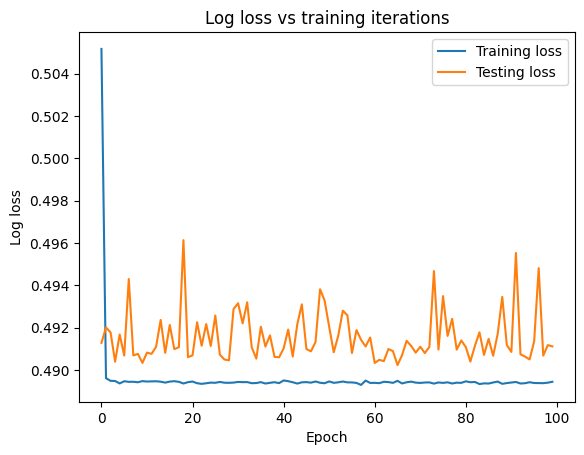

In [16]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");


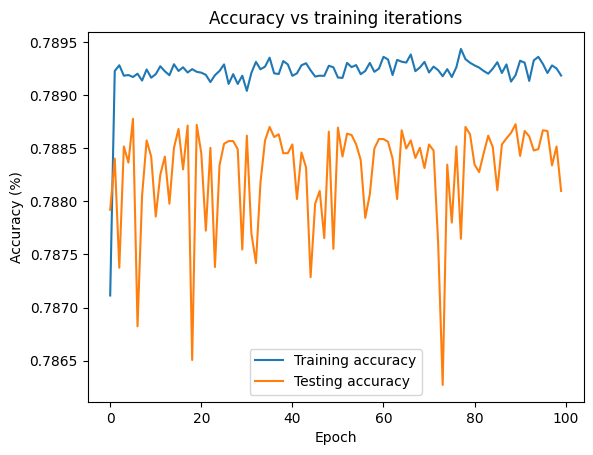

In [17]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");


In [18]:
print(f"Final training log loss: {train_losses[-1]:.3f}")
print(f"Final testing log Loss: {test_losses[-1]:.3f}")


Final training log loss: 0.489
Final testing log Loss: 0.491


In [19]:
print(f"Final training accuracy: {train_accs[-1]:.3f}")
print(f"Final testing accuracy: {test_accs[-1]:.3f}")


Final training accuracy: 0.789
Final testing accuracy: 0.788


In [29]:
Y_train

array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [30]:
def show_confusion_matrix(y, y_classes, typ):
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(y, y_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = range(2)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title(f"Confusion matrix: {typ}")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

y_pred_train, y_pred_test = log_reg(X_train, train=False), log_reg(X_test, train=False)
train_classes, test_classes = predict_class(y_pred_train), predict_class(y_pred_test)


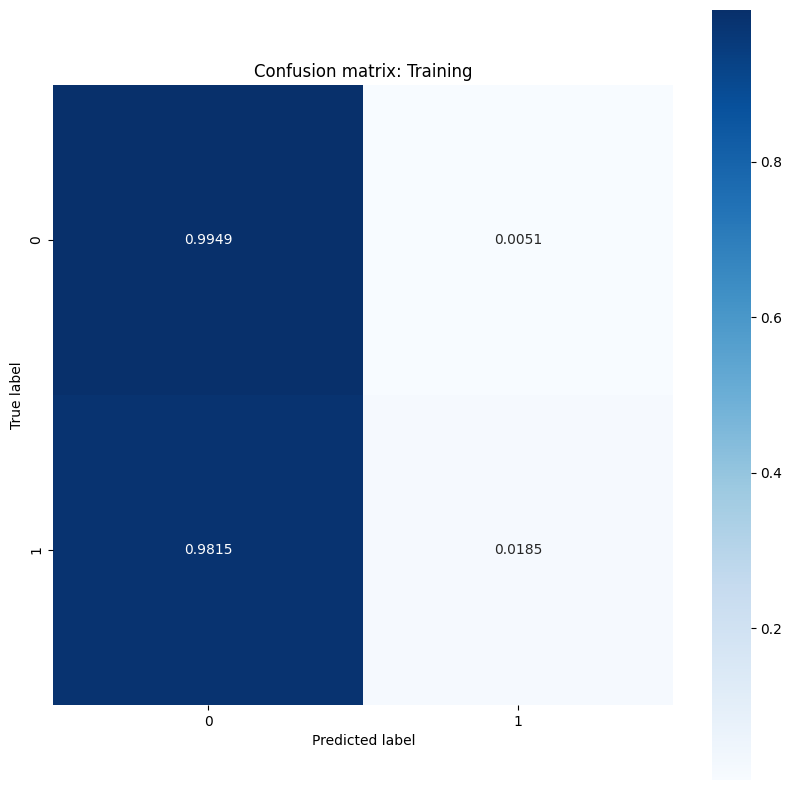

In [31]:
from sklearn import metrics as sk_metrics
show_confusion_matrix(Y_train, train_classes, 'Training')


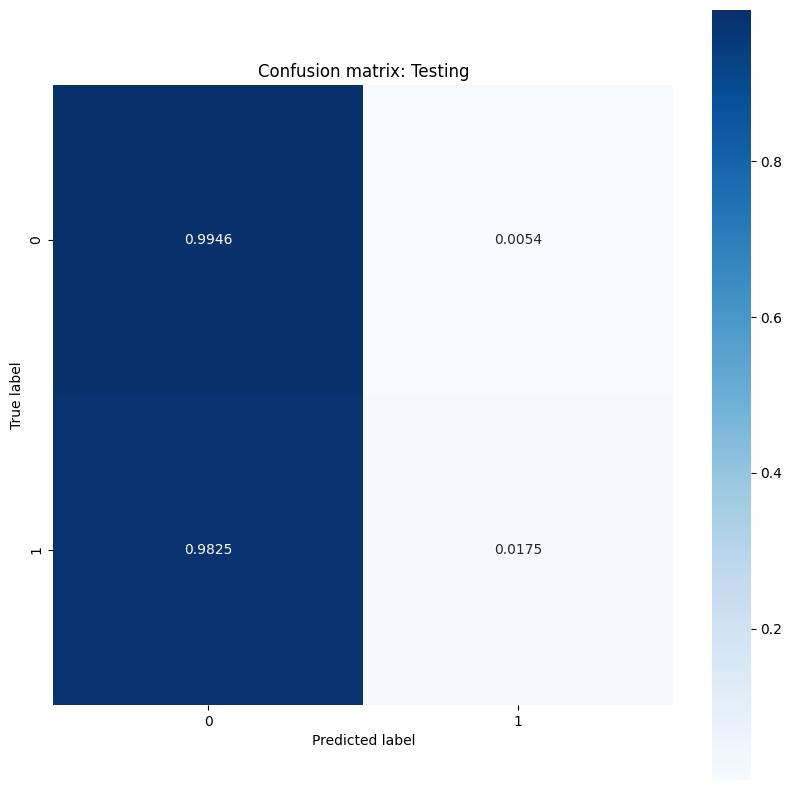

In [32]:
show_confusion_matrix(Y_test, test_classes, 'Testing')


In [41]:
class ExportModule(tf.Module):
  def __init__(self, model, norm_x, class_pred):
    # Initialize pre- and post-processing functions
    self.model = model
    self.norm_x = norm_x
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
  def __call__(self, x):
    # Run the `ExportModule` for new data points
    x = self.norm_x
    y = self.model(x, train=False)
    y = self.class_pred(y)
    return y

In [45]:
log_reg_export = ExportModule(model=log_reg,
                              norm_x=tf_X_train,
                              class_pred=predict_class)


In [48]:
import os 
#models = tempfile.mkdtemp()
models = '/home/fuzzman113/Machine_Learning/Deep_Learning/'
save_path = os.path.join(models, 'log_reg_export')
tf.saved_model.save(log_reg_export, save_path)


INFO:tensorflow:Assets written to: /home/fuzzman113/Machine_Learning/Deep_Learning/log_reg_export/assets


INFO:tensorflow:Assets written to: /home/fuzzman113/Machine_Learning/Deep_Learning/log_reg_export/assets


In [ ]:
log_reg_loaded = tf.saved_model.load(save_path)
test_preds = log_reg_loaded(x_test)
test_preds[:10].numpy()


# MLP Model

In [49]:
def xavier_init(shape):
  # Computes the xavier initialization values for a weight matrix
  in_dim, out_dim = shape
  xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
  weight_vals = tf.random.uniform(shape=(in_dim, out_dim), 
                                  minval=-xavier_lim, maxval=xavier_lim, seed=22)
  return weight_vals

In [50]:
class DenseLayer(tf.Module):

  def __init__(self, out_dim, weight_init=xavier_init, activation=tf.identity):
    # Initialize the dimensions and activation functions
    self.out_dim = out_dim
    self.weight_init = weight_init
    self.activation = activation
    self.built = False

  def __call__(self, x):
    if not self.built:
      # Infer the input dimension based on first call
      self.in_dim = x.shape[1]
      # Initialize the weights and biases
      self.w = tf.Variable(self.weight_init(shape=(self.in_dim, self.out_dim)))
      self.b = tf.Variable(tf.zeros(shape=(self.out_dim,)))
      self.built = True
    # Compute the forward pass
    z = tf.add(tf.matmul(x, self.w), self.b)
    return self.activation(z)


In [51]:
class MLP(tf.Module):

  def __init__(self, layers):
    self.layers = layers

  @tf.function
  def __call__(self, x, preds=False): 
    # Execute the model's layers sequentially
    for layer in self.layers:
      x = layer(x)
    return x

In [163]:
hidden_layer_1_size = 300
hidden_layer_2_size = 150
hidden_layer_3_size = 80
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_3_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])


In [105]:
def cross_entropy_loss(y_pred, y):
  # Compute cross entropy loss with a sparse operation
  #print(y)
  #print(y_pred)
  #print(y)
  #print(y_pred)
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(sparse_ce)


In [152]:
def accuracy(y_pred, y):
  # Compute accuracy after extracting class predictions
  class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1)
  #print("class_preds:", class_preds)
  is_equal = tf.equal(y, class_preds)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))


In [55]:
class Adam:

    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize optimizer parameters and variable slots
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.built = False

    def apply_gradients(self, grads, vars):
      # Initialize variables on the first call
      if not self.built:
        for var in vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Update the model variables given their gradients
      for i, (d_var, var) in enumerate(zip(grads, vars)):
        self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
        self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      self.t += 1.
      return


In [153]:
def train_step(x_batch, y_batch, loss, acc, model, optimizer):
  # Update the model state given a batch of data
  with tf.GradientTape() as tape:
    y_pred = model(x_batch)
    #print(y_pred)
    #print(y_batch)
    batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  grads = tape.gradient(batch_loss, model.variables)
  optimizer.apply_gradients(grads, model.variables)
  return batch_loss, batch_acc

def val_step(x_batch, y_batch, loss, acc, model):
  # Evaluate the model on given a batch of validation data
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  return batch_loss, batch_acc

In [96]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
  # Initialize data structures
  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  # Format training loop and begin training
  for epoch in range(epochs):
    start = time.time()
    #print("epoch: ", epoch)  
    batch_losses_train, batch_accs_train = [], []
    batch_losses_val, batch_accs_val = [], []

    # Iterate over the training data
    for x_batch, y_batch in train_data:
      # Compute gradients and update the model's parameters
      #print(y_batch)
      batch_loss, batch_acc = train_step(x_batch, y_batch, loss, acc, mlp, optimizer)
      # Keep track of batch-level training performance
      batch_losses_train.append(batch_loss)
      batch_accs_train.append(batch_acc)

    # Iterate over the validation data
    for x_batch, y_batch in val_data:
      batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
      batch_losses_val.append(batch_loss)
      batch_accs_val.append(batch_acc)

    # Keep track of epoch-level model performance
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch: {epoch}")
    print(f"Training loss: {train_loss:.3f}, Training accuracy: {train_acc:.3f}")
    print(f"Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")
    end = time.time()
    print("time: ", end - start)
  return train_losses, train_accs, val_losses, val_accs

In [156]:
x = log_final_data_in.drop(columns = ['bin_outcome','2_wk_close_pct'])
x_out = log_final_data_out.drop(columns = ['bin_outcome','2_wk_close_pct'])

y = log_final_data_in[['bin_outcome']] 
y_out = log_final_data_out[['bin_outcome']]

X_train, X_test, Y_train, Y_test = train_test_split( x, y, test_size=0.2, random_state=2)

In [157]:
X_train = np.asarray(X_train).astype('float32')
Y_train = np.asarray(Y_train).astype('int64')
X_test = np.asarray(X_test).astype('float32')
Y_test = np.asarray(Y_test).astype('int64')
Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)

In [158]:
batch_size = 6
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(buffer_size=X_train.shape[0]).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
val_dataset = val_dataset.shuffle(buffer_size=X_test.shape[0]).batch(batch_size)

In [159]:
mlp_model

In [164]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_dataset, val_dataset, 
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=50)


Epoch: 0
Training loss: 2.247, Training accuracy: 0.153
Validation loss: 2.239, Validation accuracy: 0.158
time:  1950.6403357982635
Epoch: 1
Training loss: 2.230, Training accuracy: 0.161
Validation loss: 2.229, Validation accuracy: 0.163
time:  2004.1634125709534
Epoch: 2
Training loss: 2.217, Training accuracy: 0.169
Validation loss: 2.222, Validation accuracy: 0.167
time:  1970.2405006885529
Epoch: 3
Training loss: 2.206, Training accuracy: 0.173
Validation loss: 2.215, Validation accuracy: 0.171
time:  1990.051504611969
Epoch: 4
Training loss: 2.196, Training accuracy: 0.178
Validation loss: 2.212, Validation accuracy: 0.174
time:  1994.2795310020447
Epoch: 5
Training loss: 2.188, Training accuracy: 0.181
Validation loss: 2.208, Validation accuracy: 0.176
time:  2000.7976276874542
Epoch: 6
Training loss: 2.181, Training accuracy: 0.184
Validation loss: 2.202, Validation accuracy: 0.177
time:  2005.130399942398
Epoch: 7
Training loss: 2.175, Training accuracy: 0.187
Validation loss

In [165]:
def plot_metrics(train_metric, val_metric, metric_type):
  # Visualize metrics vs training Epochs
  plt.figure()
  plt.plot(range(len(train_metric)), train_metric, label = f"Training {metric_type}")
  plt.plot(range(len(val_metric)), val_metric, label = f"Validation {metric_type}")
  plt.xlabel("Epochs")
  plt.ylabel(metric_type)
  plt.legend()
  plt.title(f"{metric_type} vs Training epochs");


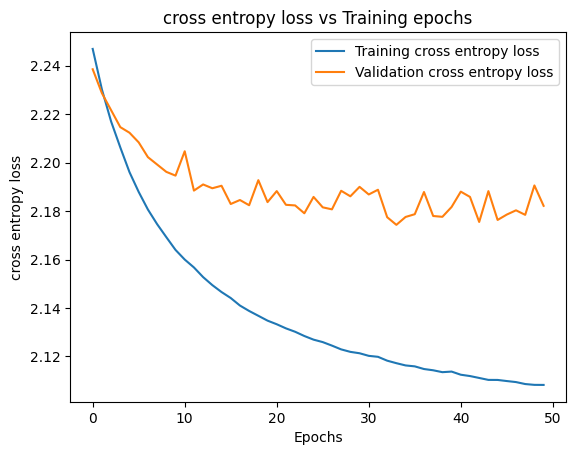

In [166]:
plot_metrics(train_losses, val_losses, "cross entropy loss")


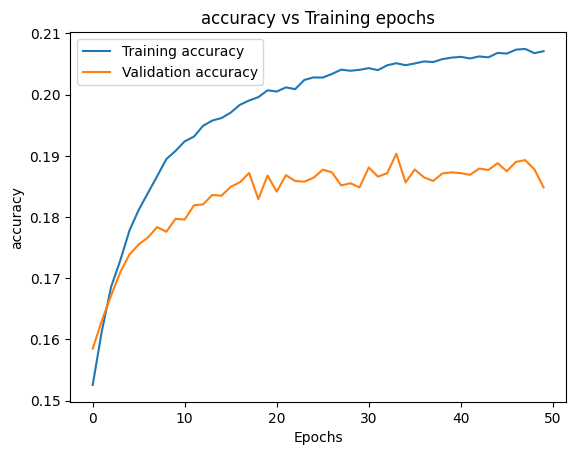

In [167]:
plot_metrics(train_accs, val_accs, "accuracy")


In [188]:
class ExportModule(tf.Module):
  def __init__(self, model, preprocess, class_pred):
    # Initialize pre and postprocessing functions
    self.model = model
    self.preprocess = preprocess
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, 216], dtype=tf.float32)]) 
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.preprocess(x)
    y = self.model(x)
    y = self.class_pred(y)
    return y

In [189]:
def preprocess_test(x):
  # The export module takes in unprocessed and unlabeled data
  x = tf.reshape(x, shape=[-1, 216])
  #x = x/255
  return x

def class_pred_test(y):
  # Generate class predictions from MLP output
  return tf.argmax(tf.nn.softmax(y), axis=1)


In [190]:
mlp_model_export = ExportModule(model=mlp_model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)


In [191]:
models = '/home/fuzzman113/Machine_Learning/Deep_Learning/'
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)


INFO:tensorflow:Assets written to: /home/fuzzman113/Machine_Learning/Deep_Learning/mlp_model_export/assets


INFO:tensorflow:Assets written to: /home/fuzzman113/Machine_Learning/Deep_Learning/mlp_model_export/assets


In [192]:
mlp_loaded = tf.saved_model.load(save_path)


In [ ]:
y_out = np.asarray(y_out).astype('float32')
y_out = y_out.reshape(-1)


In [185]:
x_out = np.asarray(x_out).astype('float32')

In [193]:
def accuracy_score(y_pred, y):
  # Generic accuracy function
  is_equal = tf.equal(y_pred, y)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))


test_classes = mlp_loaded(x_out)
test_acc = accuracy_score(test_classes, y_out)
print(f"Test Accuracy: {test_acc:.3f}")


Test Accuracy: 0.117


In [195]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
  label_ind = (y_out == label)
  # extract predictions for specific true label
  pred_label = test_classes[label_ind]
  labels = y_out[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(pred_label, labels).numpy()] = label
for key in sorted(label_accs):
  print(f"Digit {label_accs[key]}: {key:.3f}")


Accuracy breakdown by digit:
---------------------------
Digit 5: 0.000
Digit 1: 0.002
Digit 6: 0.030
Digit 3: 0.100
Digit 4: 0.102
Digit 2: 0.117
Digit 7: 0.163
Digit 0: 0.219
Digit 8: 0.234
Digit 9: 0.266


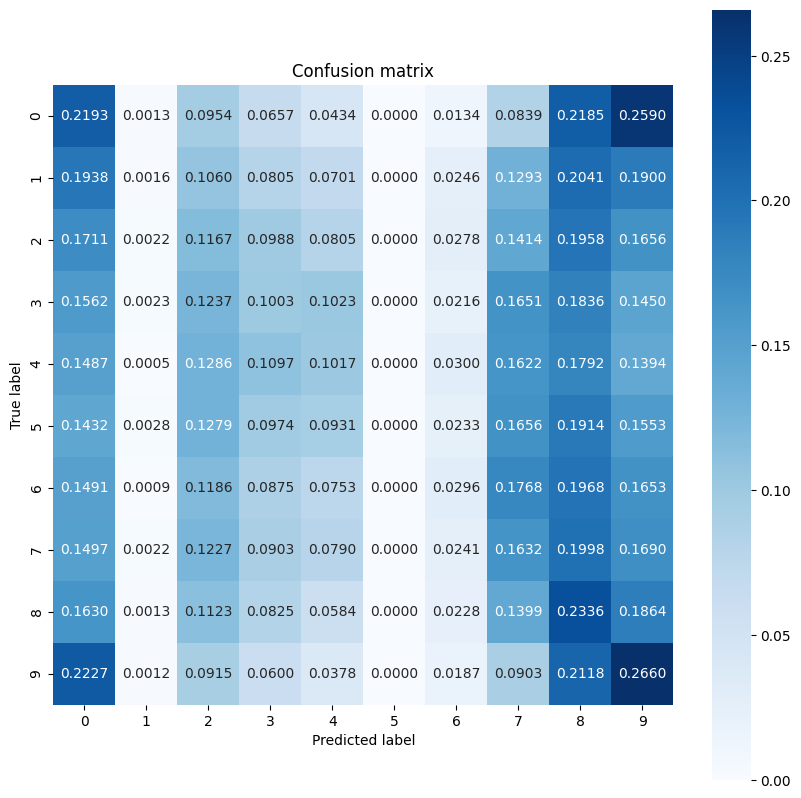

In [197]:
import sklearn.metrics as sk_metrics

def show_confusion_matrix(test_labels, test_classes):
  # Compute confusion matrix and normalize
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(test_labels, 
                                          test_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = range(10)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(y_out, test_classes)


#### In conclusion, and this does not come as a particular surprise, but it is extremely difficult to forcast with a level of accuracy how stocks will perform over time.  Variables were initially chosen based on research of popular technical and fundamental indicators.  A test/train split was created, along with a separate out of time validation set which is generally appropriate for most time-series type models as they can be events which create bias which will not show in an in-time validation.  From there, after review of the histograms and coolinearity, outliers were removed and the variables rescaled.  

#### A logistic model was built over several epochs in order to identify the gradient descent.  While it could not predict the vast majority of equities, this model suprisingly performed better than expected.  Effectively, it is able to identify stocks which will increase in value by 5% with a 3-1 success rate.  Subsequently, an MLP classification model was attempted. This model suffered from the fact that most equities are not forecastable, and the bins were so large it could not capture the outliers that we are targetting.

#### In conclusion the logistic model, while not being able to forecast the majority of equities, performed well with our objectives.  It has fairly poor recall, meaning it is not capturing most of the stocks with a 5% upward movement, it has decent precision, once it makes a prediction it is correct 60+% of the time.